In [ ]:
!pip install -q timm albumentations==1.3.0 xgboost optuna keras-tuner

import os, random, time, math, json
from pathlib import Path
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.feature import hog

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [ ]:
import zipfile
import os

zip_path = "/content/archive (8).zip"
extract_to = "/content/waste_dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Extraction completed!")


Extraction completed!


dataset desc

In [ ]:
import os
import pandas as pd
from PIL import Image
from collections import Counter
from IPython.display import display, HTML

# -----------------------------
# CONFIG
# -----------------------------
dataset_root = "/content/waste_dataset"   # <-- change if needed
image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff", ".webp"}

# -----------------------------
# LOAD IMAGE PATHS & LABELS
# -----------------------------
records = []

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if os.path.splitext(file.lower())[1] in image_extensions:
            path = os.path.join(root, file)
            label = os.path.basename(root)
            records.append((path, label))

# Convert to DataFrame
df = pd.DataFrame(records, columns=["path", "label"])

print("✔ Total images found:", len(df))
print("✔ Total classes:", df['label'].nunique())

# -----------------------------
# CLASS DISTRIBUTION
# -----------------------------
class_counts = df['label'].value_counts()
class_percent = (class_counts / len(df) * 100).round(2)

df_class = pd.DataFrame({
    "Class": class_counts.index,
    "Images": class_counts.values,
    "Percentage (%)": class_percent.values
})

print("\n🔹 Class Distribution:")
display(df_class)

# -----------------------------
# IMAGE SIZE SUMMARY PER CLASS
# -----------------------------
widths = []
heights = []
areas = []

for path in df["path"]:
    try:
        img = Image.open(path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        areas.append(w*h)
    except:
        widths.append(None)
        heights.append(None)
        areas.append(None)

df["width"] = widths
df["height"] = heights
df["area"] = areas

# Global stats
df_sizes = pd.DataFrame({
    "Metric": ["Min Width", "Max Width", "Avg Width",
               "Min Height", "Max Height", "Avg Height",
               "Min Area", "Max Area", "Avg Area"],
    "Value": [
        df["width"].min(), df["width"].max(), round(df["width"].mean(), 2),
        df["height"].min(), df["height"].max(), round(df["height"].mean(), 2),
        df["area"].min(), df["area"].max(), round(df["area"].mean(), 2),
    ]
})

print("\n🔹 Image Size Summary:")
display(df_sizes)

# -----------------------------
# QUICK OVERVIEW TABLE (first 20 rows)
# -----------------------------
print("\n🔹 Dataset Overview (first 20 rows):")
display(df.head(20))



✔ Total images found: 2527
✔ Total classes: 6

🔹 Class Distribution:


,Class,Images,Percentage (%)
0,paper,594,23.51
1,glass,501,19.83
2,plastic,482,19.07
3,metal,410,16.22
4,cardboard,403,15.95
5,trash,137,5.42



🔹 Image Size Summary:


,Metric,Value
0,Min Width,512.0
1,Max Width,512.0
2,Avg Width,512.0
3,Min Height,384.0
4,Max Height,384.0
5,Avg Height,384.0
6,Min Area,196608.0
7,Max Area,196608.0
8,Avg Area,196608.0



🔹 Dataset Overview (first 20 rows):


,path,label,width,height,area
0,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
1,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
2,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
3,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
4,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
5,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
6,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
7,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
8,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608
9,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608


Cell A — quick discovery + lightweight EDA (fast)

In [ ]:
# Cell A — quick discovery + lightweight EDA (fast)
import os
from pathlib import Path
from PIL import Image, ImageFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Corrected dataset_root path
dataset_root = "/content/waste_dataset"
out = "/data/eda_output"
os.makedirs(out, exist_ok=True)

img_exts = {'.jpg','.jpeg','.png','.bmp','.tif','.tiff'}
files = [p for p in Path(dataset_root).rglob("*") if p.suffix.lower() in img_exts]
print("Found images:", len(files))

rows = []
import hashlib
for p in files:
    try:
        im = Image.open(p).convert('RGB')
        w,h = im.size
        arr = np.array(im)
        mean_rgb = arr.reshape(-1,3).mean(axis=0)
        md5 = hashlib.md5(Image.fromarray(arr).resize((64,64)).convert('L').tobytes()).hexdigest()
        rows.append({'path':str(p),'label':p.parent.name,'width':w,'height':h,
                     'mean_r':float(mean_rgb[0]),'mean_g':float(mean_rgb[1]),'mean_b':float(mean_rgb[2]),
                     'md5_small':md5})
    except Exception as e:
        continue

df_basic = pd.DataFrame(rows)
df_basic.to_csv(os.path.join(out,'image_table_basic.csv'), index=False)
print("Saved image_table_basic.csv with", len(df_basic), "rows at", out)

# quick plots
plots_dir = os.path.join(out,'plots_fast')
os.makedirs(plots_dir, exist_ok=True)
label_counts = df_basic['label'].value_counts().reset_index()
label_counts.columns = ['label','count']
label_counts.to_csv(os.path.join(out,'label_counts_fast.csv'), index=False)

plt.figure(figsize=(10,6)); sns.barplot(data=label_counts, x='label', y='count'); plt.xticks(rotation=45,ha='right'); plt.title('Class distribution'); plt.tight_layout(); plt.savefig(os.path.join(plots_dir,'class_distribution_fast.png')); plt.close()
df_basic['area'] = df_basic['width']*df_basic['height']
plt.figure(figsize=(8,5)); sns.histplot(df_basic['area'], bins=50); plt.title('Image area distribution'); plt.tight_layout(); plt.savefig(os.path.join(plots_dir,'area_fast.png')); plt.close()
df_basic['aspect_ratio'] = df_basic['width']/df_basic['height']
plt.figure(figsize=(8,5)); sns.histplot(df_basic['aspect_ratio'], bins=50); plt.title('Aspect ratio'); plt.tight_layout(); plt.savefig(os.path.join(plots_dir,'aspect_fast.png')); plt.close()

print("Fast plots saved to", plots_dir)

Found images: 2527
Saved image_table_basic.csv with 2527 rows at /data/eda_output
Fast plots saved to /data/eda_output/plots_fast


Cell B — per-image features (HOG, edges, blur) — takes longer

In [ ]:
# Cell B — compute per-image features (HOG, edges, laplacian var, edge_count)
# Run this after Cell A. This can take minutes for ~2.5k images.
import cv2
from skimage.feature import hog
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
import os, json

in_csv = "/data/eda_output/image_table_basic.csv"   # <- updated path
out = "/content/eda_output"
os.makedirs(out, exist_ok=True) # Added this line to create the output directory
df = pd.read_csv(in_csv)

rows = []
for idx, r in df.iterrows():
    p = r['path']
    try:
        arr_bgr = cv2.imread(p)
        if arr_bgr is None:
            raise ValueError("cv2.imread failed")
        arr = cv2.cvtColor(arr_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        edges = cv2.Canny(gray,100,200)
        edge_count = int(edges.sum()//255)
        hog_feat = hog(gray, pixels_per_cell=(16,16), cells_per_block=(1,1), feature_vector=True)
        rows.append({'path':p,'laplacian_var':float(lap_var),'edge_count':edge_count,'hog_len':len(hog_feat),'hog_feat_raw':hog_feat.tolist()})
    except Exception as e:
        rows.append({'path':p,'laplacian_var':None,'edge_count':None,'hog_len':None,'hog_feat_raw':None})

df_feats = pd.DataFrame(rows)
df_out = df.merge(df_feats, on='path', how='left')
# save parquet (efficient) and a light CSV
df_out.to_parquet(os.path.join(out,'image_table_with_features.parquet'), index=False)
df_out.drop(columns=['hog_feat_raw']).to_csv(os.path.join(out,'image_table_with_features_basic.csv'), index=False)
print("Saved feature tables to", out)

Saved feature tables to /content/eda_output


In [ ]:
# Cell C — deep embeddings -> UMAP/t-SNE + clustering
# Run only if you want deep features. Use GPU runtime in Colab if possible.
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    umap_available=True
except:
    umap_available=False

df = pd.read_parquet('/content/eda_output/image_table_with_features.parquet')
paths = df['path'].tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(device).eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

batch_size = 32
embs = []
for i in range(0,len(paths),batch_size):
    batch = paths[i:i+batch_size]
    imgs = []
    for p in batch:
        try:
            im = Image.open(p).convert('RGB')
            imgs.append(preprocess(im))
        except:
            imgs.append(torch.zeros(3,224,224))
    tensor = torch.stack(imgs).to(device)
    with torch.no_grad():
        out = model(tensor).squeeze().cpu().numpy().reshape(len(batch), -1)
        embs.append(out)
embeddings = np.vstack(embs)
np.save('/content/eda_output/deep_embeddings.npy', embeddings)
print("Saved embeddings shape", embeddings.shape)

# 2D projection
if umap_available:
    reducer = umap.UMAP(n_components=2, random_state=42)
    emb2 = reducer.fit_transform(embeddings)
else:
    emb2 = TSNE(n_components=2, random_state=42, perplexity=30, init='pca').fit_transform(embeddings)

df_embed = pd.DataFrame(emb2, columns=['emb1','emb2'])
df_embed['label'] = df['label'].values
df_embed.to_csv('/content/eda_output/embeddings_2d.csv', index=False)
print("Saved embeddings 2D to /content/eda_output/embeddings_2d.csv")


Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


Saved embeddings shape (2527, 2048)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved embeddings 2D to /content/eda_output/embeddings_2d.csv


Loading data...
Loaded all tables.

=== Showing Precomputed Fast Plots ===


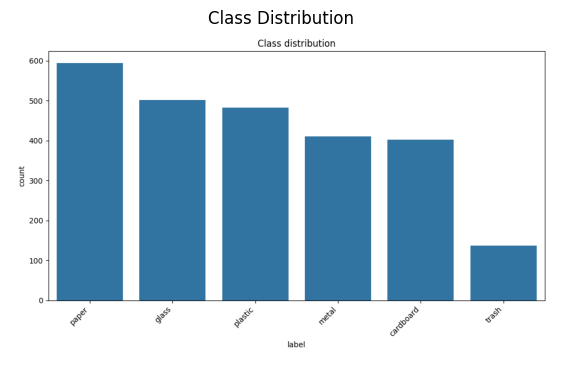


=== Showing Sample Images Per Class ===


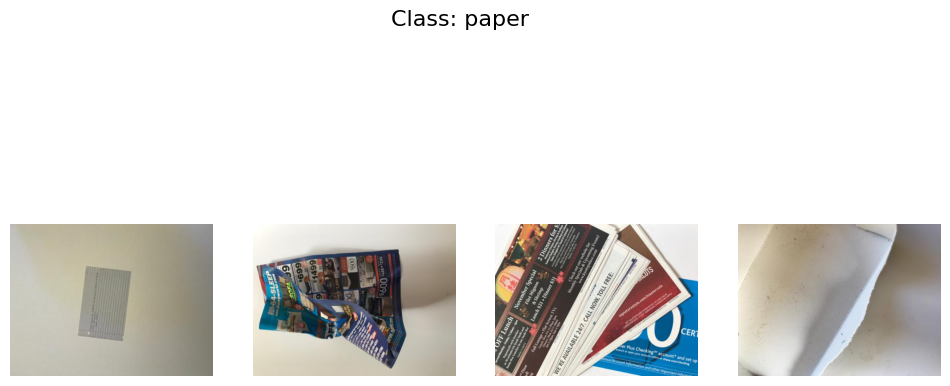

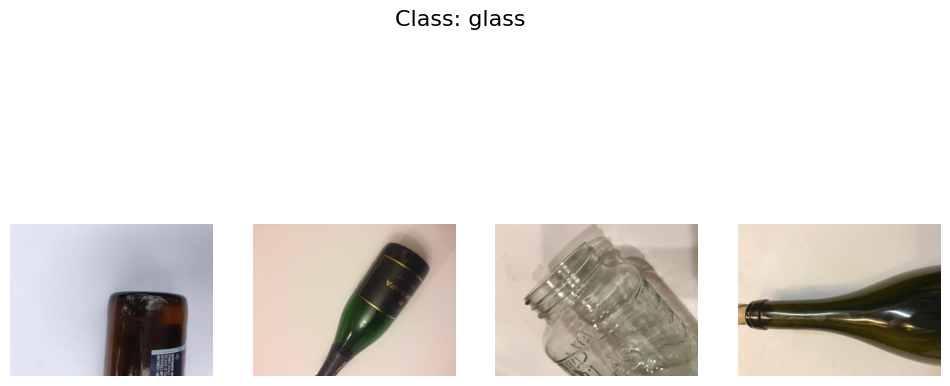

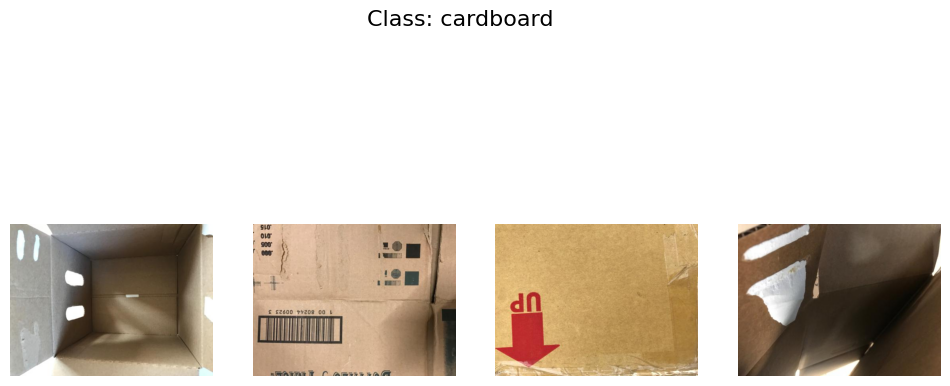

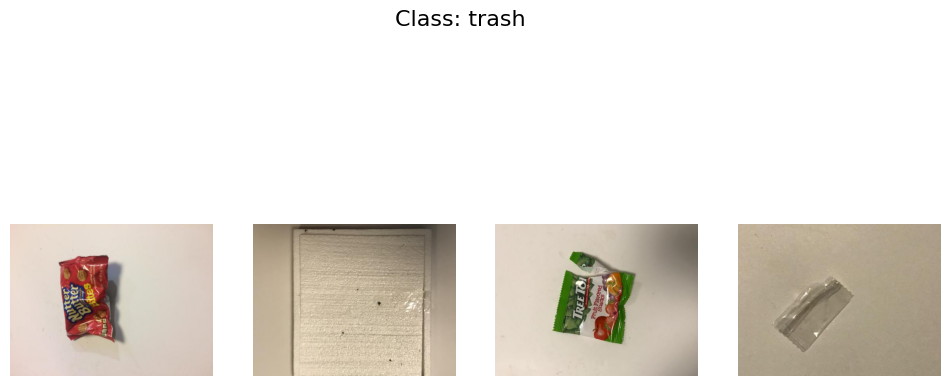

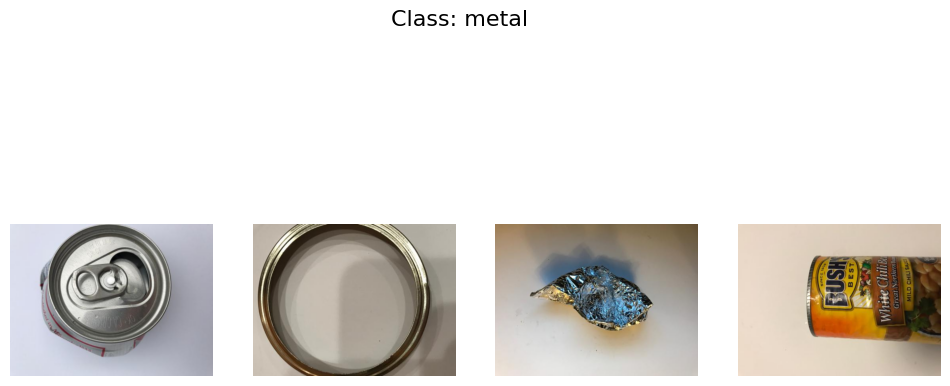

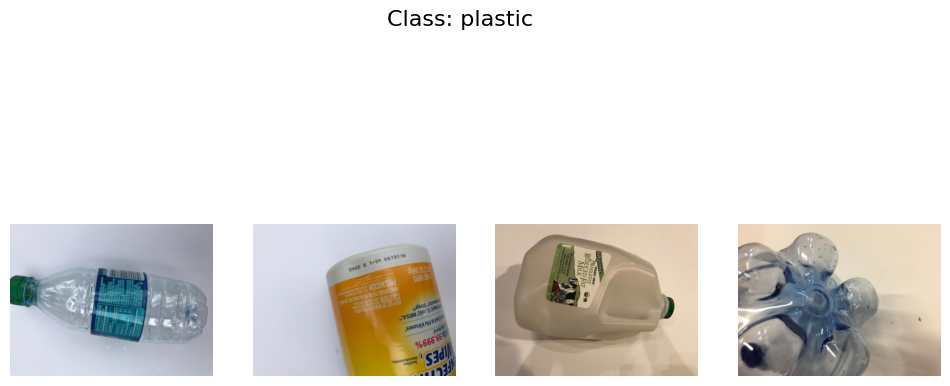


=== Random 25-Image Montage ===


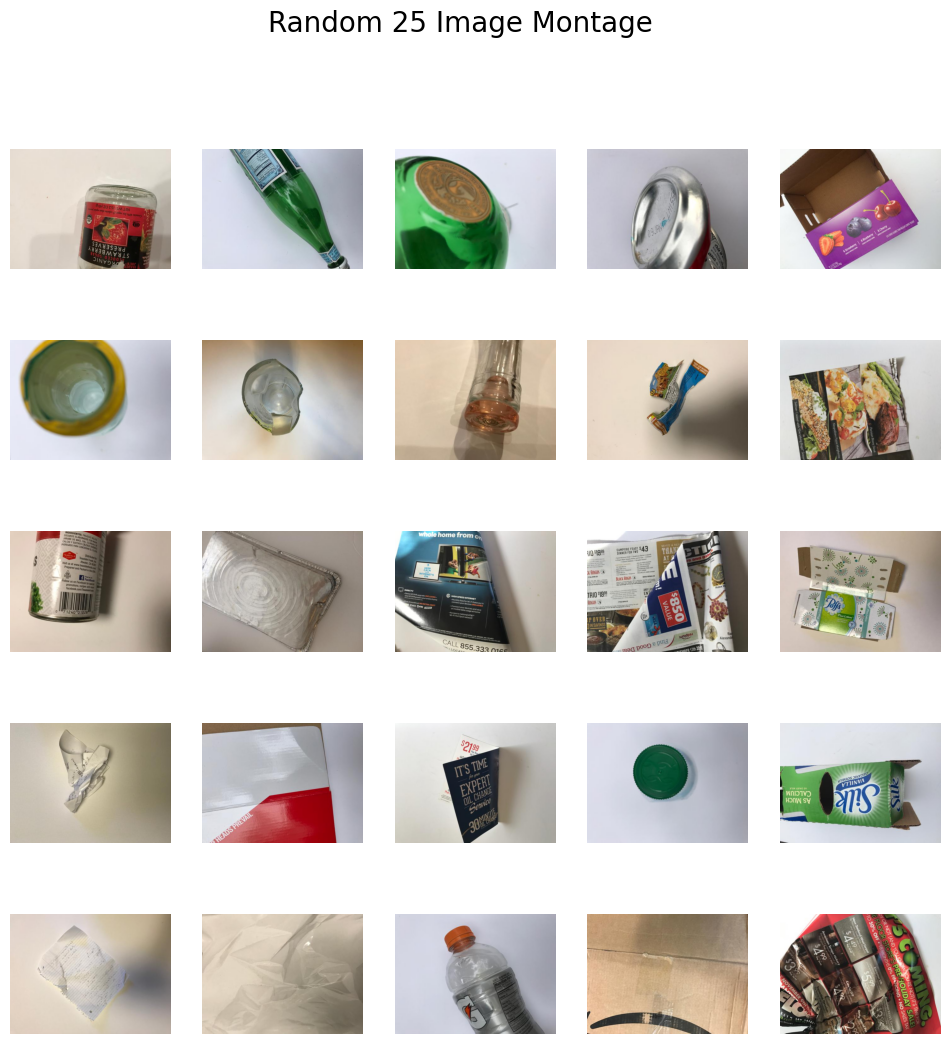


=== Blur / Edge / HOG Distributions ===


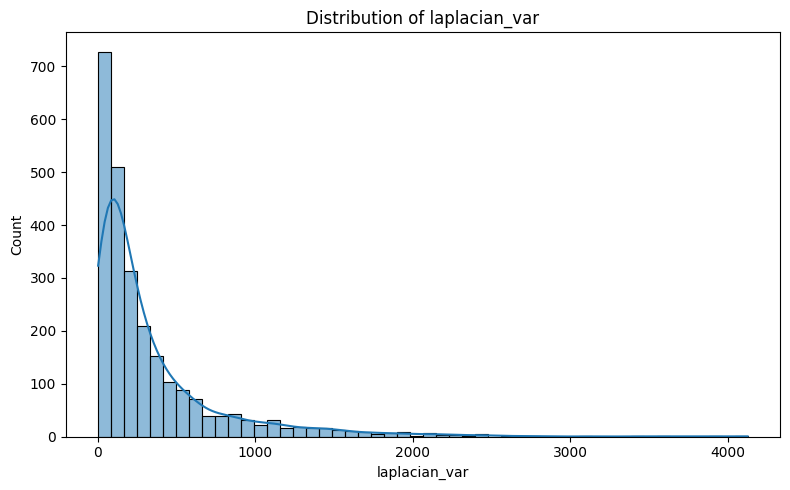

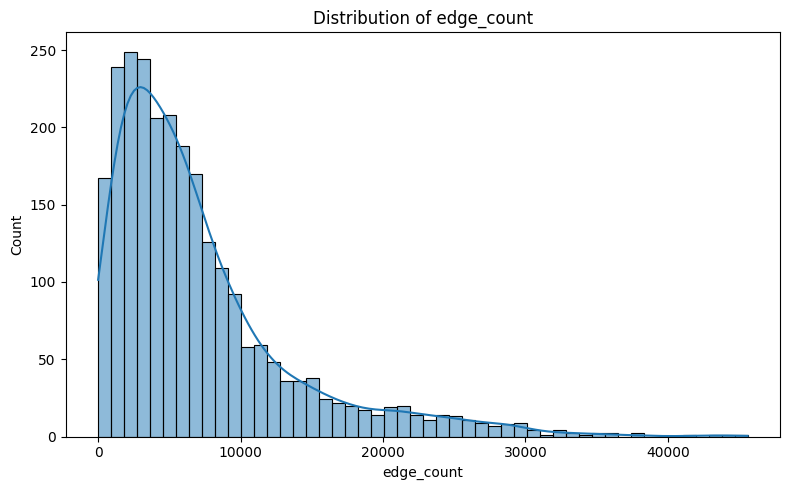

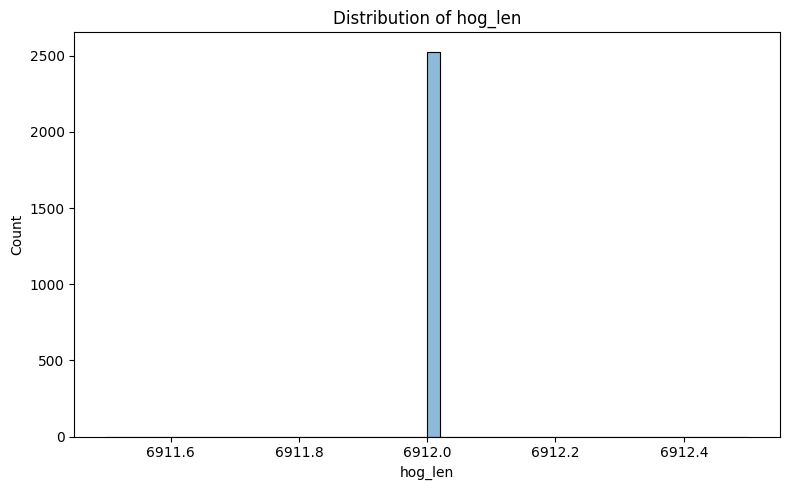


=== HOG Visualization for 4 Images ===


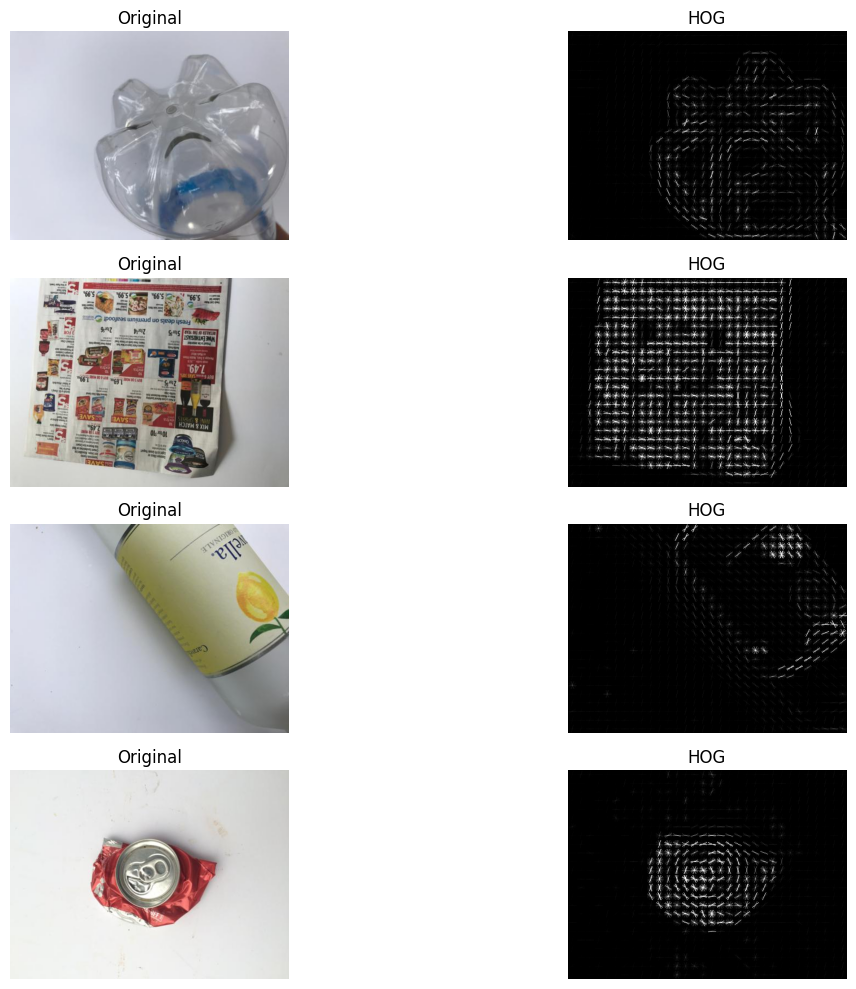


=== Deep Embedding Scatter Plot ===


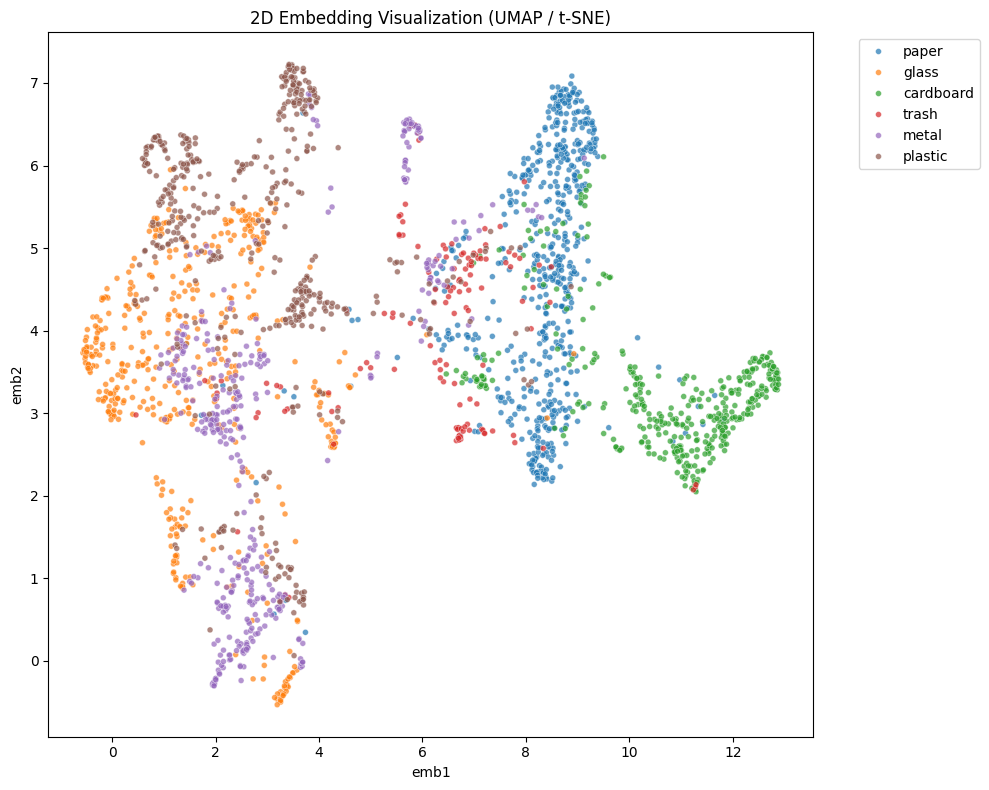


✔ FULL EDA VISUALIZATION COMPLETE!


In [ ]:
# ============================================
# FULL COMBINED VISUAL EDA CELL
# ============================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.feature import hog
from skimage import exposure

# Corrected Paths for each file
df_basic_path = "/data/eda_output/image_table_basic.csv"
df_feat_path = "/content/eda_output/image_table_with_features_basic.csv"
df_embed_path = "/content/eda_output/embeddings_2d.csv"
plots_dir = "/data/eda_output/plots_fast"

print("Loading data...")
df_basic = pd.read_csv(df_basic_path)
df_feat = pd.read_csv(df_feat_path)
df_embed = pd.read_csv(df_embed_path)
print("Loaded all tables.")

# ---------------------------
# SECTION 1 — FAST PLOTS
# ---------------------------
print("\n=== Showing Precomputed Fast Plots ===")
for fname in os.listdir(plots_dir):
    if fname.lower().startswith("class") and fname.endswith(".png"):
        img = Image.open(os.path.join(plots_dir, fname))
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.title("Class Distribution")
        plt.axis("off")
        plt.show()

# ---------------------------
# SECTION 2 — SAMPLE IMAGES PER CLASS
# ---------------------------
print("\n=== Showing Sample Images Per Class ===")
classes = df_basic['label'].unique()

for cls in classes:
    sample_paths = df_basic[df_basic['label']==cls]['path'].sample(4, random_state=42).tolist()

    plt.figure(figsize=(12,6))
    plt.suptitle(f"Class: {cls}", fontsize=16)

    for i,p in enumerate(sample_paths):
        img = Image.open(p)
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# ---------------------------
# SECTION 3 — RANDOM MONTAGE
# ---------------------------
print("\n=== Random 25-Image Montage ===")
sample_paths = df_basic['path'].sample(25, random_state=123)

plt.figure(figsize=(12,12))
for i,p in enumerate(sample_paths):
    img = Image.open(p)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Random 25 Image Montage", fontsize=20)
plt.show()

# ---------------------------
# SECTION 4 — FEATURE HISTOGRAMS
# ---------------------------
print("\n=== Blur / Edge / HOG Distributions ===")
features = ['laplacian_var', 'edge_count', 'hog_len']

for f in features:
    plt.figure(figsize=(8,5))
    sns.histplot(df_feat[f].dropna(), bins=50, kde=True)
    plt.title(f"Distribution of {f}")
    plt.tight_layout()
    plt.show()

# ---------------------------
# SECTION 5 — HOG VISUALIZATION
# ---------------------------
print("\n=== HOG Visualization for 4 Images ===")
paths = df_basic['path'].sample(4, random_state=999).tolist()

plt.figure(figsize=(14,10))
for i,p in enumerate(paths):
    img = Image.open(p).convert('RGB')
    gray = np.array(img.convert('L'))

    fd, hog_img = hog(gray, pixels_per_cell=(16,16),
                      cells_per_block=(1,1),
                      visualize=True, feature_vector=True)
    hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

    # Original
    plt.subplot(4,2,2*i+1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # HOG
    plt.subplot(4,2,2*i+2)
    plt.imshow(hog_img_rescaled, cmap='gray')
    plt.title("HOG")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ---------------------------
# SECTION 6 — EMBEDDING SCATTER (UMAP / t-SNE)
# ---------------------------
print("\n=== Deep Embedding Scatter Plot ===")
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_embed, x='emb1', y='emb2', hue='label', s=18, alpha=0.7)
plt.title("2D Embedding Visualization (UMAP / t-SNE)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n✔ FULL EDA VISUALIZATION COMPLETE!")

In [ ]:
# ============================================================
# 📊 DIRECT NOTEBOOK TABLE OVERVIEW OF DATASET
# ============================================================

import pandas as pd
import os

# Create new overview table
df_overview = df_basic.copy()

# Add file size (KB)
df_overview["file_size_kb"] = df_overview["path"].apply(lambda p: round(os.path.getsize(p) / 1024, 2))

# Calculate area and aspect_ratio here to ensure they exist
df_overview['area'] = df_overview['width'] * df_overview['height']
df_overview['aspect_ratio'] = df_overview['width'] / df_overview['height']

# Reorder columns for clean display
df_overview = df_overview[[
    "path", "label", "width", "height", "area", "aspect_ratio", "file_size_kb"
]]

# Show first 20 rows
print("=== 📘 DATASET OVERVIEW (First 20 Images) ===")
display(df_overview.head(20))

# Show class distribution
print("\n=== 📊 CLASS DISTRIBUTION ===")
display(df_overview["label"].value_counts().rename("count").to_frame())

# Show descriptive stats
print("\n=== 📈 IMAGE SIZE SUMMARY ===")
display(df_overview[["width", "height", "area", "aspect_ratio", "file_size_kb"]].describe())

=== 📘 DATASET OVERVIEW (First 20 Images) ===


,path,label,width,height,area,aspect_ratio,file_size_kb
0,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,14.48
1,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,24.58
2,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,26.44
3,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,45.01
4,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,27.94
5,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,15.31
6,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,12.85
7,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,25.80
8,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,9.09
9,/content/waste_dataset/dataset-resized/paper/p...,paper,512,384,196608,1.333333,12.46



=== 📊 CLASS DISTRIBUTION ===


,count
label,
paper,594
glass,501
plastic,482
metal,410
cardboard,403
trash,137



=== 📈 IMAGE SIZE SUMMARY ===


,width,height,area,aspect_ratio,file_size_kb
count,2527.0,2527.0,2527.0,2.527000e+03,2527.000000
mean,512.0,384.0,196608.0,1.333333e+00,16.726518
std,0.0,0.0,0.0,4.108638e-14,7.420662
min,512.0,384.0,196608.0,1.333333e+00,5.470000
25%,512.0,384.0,196608.0,1.333333e+00,11.630000
50%,512.0,384.0,196608.0,1.333333e+00,15.020000
75%,512.0,384.0,196608.0,1.333333e+00,19.825000
max,512.0,384.0,196608.0,1.333333e+00,56.510000


PREPROCESSING


In [ ]:
# ============================================================
# 🔧 DATA PREPROCESSING PIPELINE
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2


# ------------------------------------------------------------
# 1️⃣ LABEL ENCODING
# ------------------------------------------------------------

df = df_basic.copy()

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

num_classes = len(label_encoder.classes_)
print("Label classes:", label_encoder.classes_)
print("Encoded as:", list(range(num_classes)))


# ------------------------------------------------------------
# 2️⃣ TRAIN / VALIDATION / TEST SPLIT
# stratified → preserves class balance
# ------------------------------------------------------------

train_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df["label_encoded"], random_state=42
)

train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["label_encoded"], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Val size:   {len(val_df)}")
print(f"Test size:  {len(test_df)}")


# ------------------------------------------------------------
# 3️⃣ NORMALIZATION VALUES (ImageNet)
# ------------------------------------------------------------

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)


# ------------------------------------------------------------
# 4️⃣ DATA AUGMENTATION PIPELINES (Albumentations)
# Light for validation/test
# Heavy for training
# ------------------------------------------------------------

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),

    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.20, rotate_limit=25,
        border_mode=cv2.BORDER_REFLECT_101, p=0.5
    ),

    A.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4
    ),

    A.GaussianBlur(blur_limit=3, p=0.2),
    A.CoarseDropout(max_holes=5, max_height=32, max_width=32, p=0.4),

    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2(),
])


# ------------------------------------------------------------
# 5️⃣ CUSTOM DATASET CLASS
# ------------------------------------------------------------

class WasteDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row["path"]
        label = row["label_encoded"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, torch.tensor(label, dtype=torch.long)


# ------------------------------------------------------------
# 6️⃣ CREATE DATASETS & DATALOADERS
# ------------------------------------------------------------

train_dataset = WasteDataset(train_df, transform=train_transform)
val_dataset   = WasteDataset(val_df,   transform=val_test_transform)
test_dataset  = WasteDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

print("DataLoaders ready!")


# ------------------------------------------------------------
# OPTIONAL: CLASS WEIGHTS (to handle imbalance)
# ------------------------------------------------------------
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_encoded"]),
    y=train_df["label_encoded"]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights_tensor)


Label classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Encoded as: [0, 1, 2, 3, 4, 5]
Train size: 2046
Val size:   228
Test size:  253
DataLoaders ready!
Class weights: tensor([1.0428, 0.8399, 1.0271, 0.7104, 0.8744, 3.0721])


/usr/local/lib/python3.12/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


FEATURE ENGINGEERING

In [ ]:
# ================================================
# FIXED FEATURE EXTRACTION (HOG + COLOR HISTOGRAM)
# ================================================

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# Helper: resize & crop
# -------------------------------
def read_and_center_crop_resize(path, size=(128,128)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]
    m = min(h, w)
    start_x = (w - m) // 2
    start_y = (h - m) // 2
    img = img[start_y:start_y+m, start_x:start_x+m]
    img = cv2.resize(img, size)
    return img

# -------------------------------
# HOG feature extractor
# -------------------------------
def extract_hog(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return hog(gray,
               orientations=9,
               pixels_per_cell=(16, 16),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               feature_vector=True)

# -------------------------------
# Color Histogram
# -------------------------------
def color_hist(img, bins=32):
    r = np.histogram(img[:, :, 0], bins=bins, range=(0, 255))[0]
    g = np.histogram(img[:, :, 1], bins=bins, range=(0, 255))[0]
    b = np.histogram(img[:, :, 2], bins=bins, range=(0, 255))[0]
    hist = np.concatenate([r, g, b]).astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist

# -------------------------------
# Build Features
# -------------------------------
def build_features(df_rows):
    X = []
    y = [] # y is not used in this cell for return, but kept for consistency with original build_features signature
    for p, label in tqdm(zip(df_rows.path.values, df_rows.label.values), total=len(df_rows)):
        img = read_and_center_crop_resize(p)
        hog_f = extract_hog(img)
        col_f = color_hist(img)
        feat = np.hstack([hog_f, col_f])
        X.append(feat)
        y.append(label) # Still appending to y, but y is not returned here
    return np.vstack(X)

# -------------------------------
# Generate Feature Vectors using pre-existing splits
# -------------------------------
# train_df, val_df, test_df are already available from the PREPROCESSING cell
X_train = build_features(train_df)
X_val = build_features(val_df)
X_test = build_features(test_df)

# Extract encoded labels from the dataframes
y_train_enc = train_df['label_encoded'].values
y_val_enc = val_df['label_encoded'].values
y_test_enc = test_df['label_encoded'].values

print("Feature shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train_enc: {y_train_enc.shape}")
print(f"y_val_enc:   {y_val_enc.shape}")
print(f"y_test_enc:  {y_test_enc.shape}")

100%|██████████| 253/253 [00:01<00:00, 213.41it/s]

Feature shapes:
X_train: (2046, 1860)
X_val:   (228, 1860)
X_test:  (253, 1860)
y_train_enc: (2046,)
y_val_enc:   (228,)
y_test_enc:  (253,)


ML MODELS

In [ ]:
# ============================================
# Evaluation Helper (REQUIRED BEFORE ML MODELS)
# ============================================

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

def detailed_metrics(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_rec = recall_score(y_true, y_pred, average='macro', zero_division=0)

    cls_report = classification_report(
        y_true, y_pred, target_names=labels if labels is not None else None,
        zero_division=0
    )

    conf = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "classification_report": cls_report,
        "confusion_matrix": conf
    }

print("Detailed metrics function loaded!")


Detailed metrics function loaded!


ML MODELS

In [ ]:
# ============================================
# CELL — Classical ML Models: Train + Evaluate
# ============================================

import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score
import xgboost as xgb

SEED = 42

# -----------------------------
# Define all ML models
# -----------------------------
models_ml = {
    "SVM_rbf": SVC(kernel='rbf', C=1.0, probability=True, random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=250, max_depth=None, random_state=SEED),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogisticRegression": LogisticRegression(max_iter=800),
    "NaiveBayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=SEED,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6
    )
}

# -----------------------------
# Train + Evaluate
# -----------------------------
ml_metrics = {}

for name, clf in models_ml.items():
    print("\n======================================")
    print(f"Training / Evaluating: {name}")
    print("======================================")

    # pipeline (Scaling → Model)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

    pipe.fit(X_train, y_train_enc)
    preds = pipe.predict(X_test)

    # use your helper function
    m = detailed_metrics(y_test_enc, preds)
    ml_metrics[name] = m

    print(f"\n{name}")
    print(f"Accuracy: {m['accuracy']:.4f}")
    print(f"Macro-F1: {m['macro_f1']:.4f}")
    print("\nClassification Report:")
    print(m["classification_report"])

# -----------------------------
# Save summary metrics
# -----------------------------
save_path = "/content/ml_metrics_summary.json"
with open(save_path, "w") as f:
    json.dump(
        {k: {"accuracy": v["accuracy"], "macro_f1": v["macro_f1"]} for k, v in ml_metrics.items()},
        f,
        indent=4
    )

print(f"\nSaved summary metrics to:\n{save_path}")
print("\n✅ Classical ML Training Complete!")


Training / Evaluating: SVM_rbf

SVM_rbf
Accuracy: 0.6719
Macro-F1: 0.6309

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74        40
           1       0.59      0.66      0.62        50
           2       0.57      0.49      0.53        41
           3       0.79      0.88      0.83        60
           4       0.58      0.65      0.61        48
           5       1.00      0.29      0.44        14

    accuracy                           0.67       253
   macro avg       0.72      0.61      0.63       253
weighted avg       0.68      0.67      0.66       253


Training / Evaluating: RandomForest

RandomForest
Accuracy: 0.6759
Macro-F1: 0.6149

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        40
           1       0.52      0.68      0.59        50
           2       0.63      0.59      0.61        41
           3       0.73      0.8

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:40:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
Accuracy: 0.7549
Macro-F1: 0.7187

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        40
           1       0.69      0.68      0.69        50
           2       0.74      0.61      0.67        41
           3       0.77      0.97      0.86        60
           4       0.71      0.77      0.74        48
           5       0.67      0.43      0.52        14

    accuracy                           0.75       253
   macro avg       0.75      0.71      0.72       253
weighted avg       0.76      0.75      0.75       253


Saved summary metrics to:
/content/ml_metrics_summary.json

✅ Classical ML Training Complete!


### Classical ML models — citations & context (authors from your spreadsheet)

**SVM (Support Vector Machine)**
- **Used by:** Adedeji & Wang (2019) — "Intelligent Waste Classification System Using Deep Learning Convolutional Neural Network" (SVM as classifier on extracted features).
- **Why used in those papers:** Strong baseline classifier for small feature vectors; good margin-based generalization.



**Random Forest**
- **Used by:** used as baseline in multiple studies (comparative sections in Altikat et al., various review papers).
- **Why used then:** Robust to noisy features; feature importance insight.


**KNN, Logistic Regression, Naive Bayes**
- **Used by:** as baseline models across multiple early works.
- **Why used then:** Fast baselines; useful to show simple linear / instance-based limitations.

**XGBoost**
- **Used by:** as a strong gradient boosting baseline in modern applied works.




ANN

In [ ]:
# ===============================================
# MLP (ANN) ON HOG + COLOR FEATURES
# ===============================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# ---------------------------
# Dataset Wrapper
# ---------------------------
class FeatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = FeatDataset(X_train, y_train_enc)
val_ds   = FeatDataset(X_val, y_val_enc)
test_ds  = FeatDataset(X_test, y_test_enc)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)


# ---------------------------
# Model
# ---------------------------
class FeatMLP(nn.Module):
    def __init__(self, in_dim, out_dim=len(np.unique(y_train_enc))):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, out_dim)
        )

    def forward(self, x):
        return self.net(x)


model_mlp = FeatMLP(X_train.shape[1]).to(device)
opt = torch.optim.AdamW(model_mlp.parameters(), lr=1e-3, weight_decay=1e-5)
crit = nn.CrossEntropyLoss()


# ---------------------------
# Training helpers
# ---------------------------
def train_one_epoch(model, loader):
    model.train()
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)


def predict_torch(model, loader):
    model.eval()
    preds = []
    gts   = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).argmax(dim=1).cpu().numpy()
            preds.extend(out)
            gts.extend(yb.numpy())
    return np.array(gts), np.array(preds)


# ---------------------------
# Training loop
# ---------------------------
print("\n=== Training MLP on HOG + Color Features ===")
for ep in range(1, 11):
    loss = train_one_epoch(model_mlp, train_loader)
    gts_val, preds_val = predict_torch(model_mlp, val_loader)
    m = detailed_metrics(gts_val, preds_val, labels=classes)
    print(f"Epoch {ep}: loss={loss:.4f}  val_acc={m['accuracy']:.4f}  val_macroF1={m['macro_f1']:.4f}")


# ---------------------------
# Final Test Evaluation
# ---------------------------
gts_test, preds_test = predict_torch(model_mlp, test_loader)
mlp_metrics = detailed_metrics(gts_test, preds_test, labels=classes)

print("\n=== MLP Test Metrics ===")
print(f"Accuracy:   {mlp_metrics['accuracy']:.4f}")
print(f"Macro-F1:   {mlp_metrics['macro_f1']:.4f}")
print("\nClassification Report:")
print(mlp_metrics['classification_report'])


Using: cuda

=== Training MLP on HOG + Color Features ===
Epoch 1: loss=1.6333  val_acc=0.3728  val_macroF1=0.2719
Epoch 2: loss=1.4509  val_acc=0.4605  val_macroF1=0.3800
Epoch 3: loss=1.3300  val_acc=0.4825  val_macroF1=0.3959
Epoch 4: loss=1.2502  val_acc=0.4912  val_macroF1=0.3638
Epoch 5: loss=1.2033  val_acc=0.5395  val_macroF1=0.4662
Epoch 6: loss=1.1258  val_acc=0.5746  val_macroF1=0.4871
Epoch 7: loss=1.0626  val_acc=0.5395  val_macroF1=0.4617
Epoch 8: loss=1.0182  val_acc=0.5658  val_macroF1=0.5083
Epoch 9: loss=0.9535  val_acc=0.6053  val_macroF1=0.5399
Epoch 10: loss=0.9407  val_acc=0.6053  val_macroF1=0.5880

=== MLP Test Metrics ===
Accuracy:   0.5534
Macro-F1:   0.5482

Classification Report:
              precision    recall  f1-score   support

       paper       0.60      0.65      0.63        40
       glass       0.62      0.36      0.46        50
   cardboard       0.38      0.24      0.30        41
       trash       0.72      0.80      0.76        60
       metal

### ANN (MLP) on features — citations & context

- **Cited usage:** Gondal et al. (2021) included an MLP/perceptron in a hybrid pipeline; MLPs are common as simple non-linear classifiers on features.
- **Why used then:** Fast to train and useful to measure gains from learned non-linear separation over linear methods.



CNN



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ============================
# DATASET & TRANSFORMS
# ============================

data_dir = "/content/waste_dataset/dataset-resized"  # CHANGE IF NEEDED

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("CLASSES:", class_names)

# Stratified split using folder structure
from sklearn.model_selection import train_test_split

all_paths = np.array([p[0] for p in dataset.samples])
all_labels = np.array([p[1] for p in dataset.samples])

train_idx, test_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.20,
    random_state=42,
    stratify=all_labels
)

train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.18,
    random_state=42,
    stratify=all_labels[train_idx]
)

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))

# Custom subset class
from torch.utils.data import Subset

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# ============================
# METRICS FUNCTION
# ============================

def detailed_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "classification_report": classification_report(y_true, y_pred)
    }

# ============================
# CNN MODEL
# ============================

class CNNModel(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # From 128×128 → three poolings → 16 × 16 feature map
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

cnn_model = CNNModel().to(device)
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# ============================
# TRAINING & PREDICTION
# ============================

def train_one_epoch(model, loader):
    model.train()
    losses = []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return np.mean(losses)

def predict(model, loader):
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs).argmax(dim=1).cpu().numpy()
            preds.extend(out)
            gts.extend(labels.numpy())
    return np.array(gts), np.array(preds)

# ============================
# TRAIN LOOP
# ============================

for ep in range(1, 11):
    loss = train_one_epoch(cnn_model, train_loader)
    y_true, y_pred = predict(cnn_model, val_loader)
    m = detailed_metrics(y_true, y_pred)

    print(f"Epoch {ep}: loss={loss:.4f}  val_acc={m['accuracy']:.4f}  val_macroF1={m['macro_f1']:.4f}")

# ============================
# FINAL TEST EVALUATION
# ============================

y_true, y_pred = predict(cnn_model, test_loader)
results = detailed_metrics(y_true, y_pred)

print("\n===== CNN TEST METRICS =====")
print("Accuracy:", results["accuracy"])
print("Macro-F1:", results["macro_f1"])
print(results["classification_report"])


Device: cuda
CLASSES: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train: 1657 Val: 364 Test: 506


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: loss=3.5198  val_acc=0.4780  val_macroF1=0.3901
Epoch 2: loss=1.2434  val_acc=0.5604  val_macroF1=0.5218
Epoch 3: loss=1.1274  val_acc=0.6181  val_macroF1=0.5789
Epoch 4: loss=1.0596  val_acc=0.4725  val_macroF1=0.4140
Epoch 5: loss=1.0273  val_acc=0.6154  val_macroF1=0.5820
Epoch 6: loss=0.9985  val_acc=0.6429  val_macroF1=0.6093


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7: loss=0.8949  val_acc=0.4615  val_macroF1=0.3740
Epoch 8: loss=0.8644  val_acc=0.4313  val_macroF1=0.3822
Epoch 9: loss=0.8348  val_acc=0.5934  val_macroF1=0.5696
Epoch 10: loss=0.8240  val_acc=0.6264  val_macroF1=0.5988

===== CNN TEST METRICS =====
Accuracy: 0.6442687747035574
Macro-F1: 0.6149988083649323
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        81
           1       0.72      0.34      0.46       100
           2       0.57      0.57      0.57        82
           3       0.59      0.92      0.72       119
           4       0.65      0.64      0.65        97
           5       0.50      0.48      0.49        27

    accuracy                           0.64       506
   macro avg       0.65      0.62      0.61       506
weighted avg       0.66      0.64      0.63       506



### Small CNN — citations & context

**Papers referencing small/custom CNNs:** Melinte et al. (2020) used ResNeXt; many early proof-of-concept papers (e.g., Srinilta & Kanharattanachai, 2019) also used VGG/ResNet variants or custom CNNs.
**Why used then:** Demonstrate convolutional learning advantages over hand-crafted features.
**Why we use it now:** Unit-2 coverage; baseline to show transfer learning benefit.
**What to report:** Training curves, per-class precision/recall/F1, confusion matrix, and comparison vs transfer learning models.


NEW IMPROVED CNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ======================================================
# 1) DATASET WITH STRONGER PREPROCESSING + AUGMENTATION
# ======================================================

data_dir = "/content/waste_dataset/dataset-resized"

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),

    # DATA AUGMENTATION (Important)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),

    transforms.ToTensor(),

    # Normalize using ImageNet stats (helps convergence)
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=test_tf)
class_names = dataset.classes
num_classes = len(class_names)

# Stratified split
all_labels = np.array([s[1] for s in dataset.samples])
indices = np.arange(len(all_labels))

train_idx, test_idx = train_test_split(indices, test_size=0.20, random_state=42, stratify=all_labels)
train_idx, val_idx = train_test_split(train_idx, test_size=0.18, random_state=42, stratify=all_labels[train_idx])

# Apply augmentation only to train set
dataset_train = datasets.ImageFolder(data_dir, transform=train_tf)
dataset_test = datasets.ImageFolder(data_dir, transform=test_tf)

train_ds = Subset(dataset_train, train_idx)
val_ds = Subset(dataset_test, val_idx)
test_ds = Subset(dataset_test, test_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

# ======================================================
# 2) METRICS
# ======================================================

def detailed_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "classification_report": classification_report(y_true, y_pred)
    }

# ======================================================
# 3) **IMPROVED CNN: MINI-RESNET**
# ======================================================

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.short = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.short = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return nn.ReLU()(self.conv(x) + self.short(x))


class MiniResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        # Residual blocks greatly boost performance
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.classifier(x)


model = MiniResNet(num_classes).to(device)

# ======================================================
# 4) OPTIMIZER + BETTER LR SCHEDULER
# ======================================================

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.CrossEntropyLoss()

# ======================================================
# 5) TRAINING + EVAL
# ======================================================

def train_one_epoch(model, loader):
    model.train()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def predict(model, loader):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x).argmax(dim=1).cpu().numpy()
            preds.extend(out)
            gts.extend(y.numpy())
    return np.array(gts), np.array(preds)


for ep in range(1, 16):
    loss = train_one_epoch(model, train_loader)
    scheduler.step()
    y_true, y_pred = predict(model, val_loader)
    m = detailed_metrics(y_true, y_pred)
    print(f"Epoch {ep}: loss={loss:.4f} | Val Acc={m['accuracy']:.4f} | Macro-F1={m['macro_f1']:.4f}")

# Final test
y_true, y_pred = predict(model, test_loader)
final = detailed_metrics(y_true, y_pred)

print("\n===== IMPROVED CNN TEST METRICS =====")
print("Accuracy:", final["accuracy"])
print("Macro-F1:", final["macro_f1"])
print(final["classification_report"])


Device: cuda


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: loss=1.3821 | Val Acc=0.5000 | Macro-F1=0.4252
Epoch 2: loss=1.2507 | Val Acc=0.5495 | Macro-F1=0.5031


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3: loss=1.2029 | Val Acc=0.5824 | Macro-F1=0.5090
Epoch 4: loss=1.1555 | Val Acc=0.6154 | Macro-F1=0.5650
Epoch 5: loss=1.1015 | Val Acc=0.6044 | Macro-F1=0.5595
Epoch 6: loss=1.0684 | Val Acc=0.6264 | Macro-F1=0.5554
Epoch 7: loss=1.0298 | Val Acc=0.6621 | Macro-F1=0.5956
Epoch 8: loss=0.9782 | Val Acc=0.6786 | Macro-F1=0.6386
Epoch 9: loss=0.9436 | Val Acc=0.6676 | Macro-F1=0.6201
Epoch 10: loss=0.9392 | Val Acc=0.6923 | Macro-F1=0.6458
Epoch 11: loss=0.9325 | Val Acc=0.6841 | Macro-F1=0.6220
Epoch 12: loss=0.9461 | Val Acc=0.6896 | Macro-F1=0.6267
Epoch 13: loss=0.9323 | Val Acc=0.6896 | Macro-F1=0.6355
Epoch 14: loss=0.9846 | Val Acc=0.6841 | Macro-F1=0.6326
Epoch 15: loss=0.9724 | Val Acc=0.7060 | Macro-F1=0.6378

===== IMPROVED CNN TEST METRICS =====
Accuracy: 0.6857707509881423
Macro-F1: 0.6528539637308951
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        81
           1       0.57      0.82      0.67       100
      

TRANSFER LEARNING MODELS

In [ ]:
# ============================================
# FULL TRANSFER-LEARNING PIPELINE (ALL MODELS)
# Single, self-contained block — drop into Colab and run.
# - Builds image loaders (train/val/test) with stratified split
# - Creates model for each transfer architecture
# - Trains with early checkpointing (best macro-F1 on val)
# - Evaluates on test set and prints/stores metrics
#
# Notes:
# - Adjust `dataset_root` below if your images are in a different folder.
# - This block defines train_model_torch() and evaluate_model_torch() used later.
# - Saves best model files as best_<model_name>.pth in the current working dir.
# ============================================

import os
import time
import copy
import json
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# If you uploaded a zip earlier, record its local path (for reference / reproducibility)
# Developer note: uploaded file path (from conversation) => use as needed
uploaded_zip_path = "/mnt/data/archive (8).zip"

# ------------------------
# CONFIG
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# change this if your dataset folder differs
# common possibilities from our conversation: "/content/waste_dataset" or "/content/waste_dataset/dataset-resized"
# I'll try to auto-detect likely directories; override if needed.
candidates = [
    "/content/waste_dataset/dataset-resized",
    "/content/waste_dataset",
    "/content/waste_dataset/dataset",
    "/content/waste_dataset/data",
    "/content/dataset",
    "./dataset",
    "./data"
]
dataset_root = None
for c in candidates:
    if os.path.exists(c) and any(os.path.isdir(os.path.join(c,d)) for d in os.listdir(c)):
        dataset_root = c
        break
# fallback to a safe default (you can override)
if dataset_root is None:
    dataset_root = "/content/waste_dataset"   # override manually if wrong
print("Using dataset_root =", dataset_root)

# training parameters (tweak as needed)
BATCH_SIZE = 32
NUM_WORKERS = 4
EPOCHS = 8
LR = 3e-4
PATIENCE = 3  # early stopping patience (epochs without val improvement)

# ------------------------
# UTIL: metrics helper (ensures available)
# ------------------------
def detailed_metrics(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    cls_report = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
    conf = confusion_matrix(y_true, y_pred)
    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "classification_report": cls_report,
        "confusion_matrix": conf
    }

# ------------------------
# Build stratified ImageFolder dataset & splits (one function to reuse with different input sizes)
# ------------------------
from torchvision.datasets import ImageFolder

def make_loaders(root_dir, input_size=224, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, seed=42):
    """
    Creates train/val/test DataLoaders using a stratified split based on ImageFolder labels.
    Returns (train_loader, val_loader, test_loader, class_names)
    """
    # transforms: augmentation for train, simple for val/test
    train_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    # root_dir should contain subfolders per class
    dataset = ImageFolder(root_dir, transform=val_transforms)
    class_names = dataset.classes
    # build arrays of indices & labels
    indices = np.arange(len(dataset))
    labels = np.array([s[1] for s in dataset.samples])

    # first split: train (70%), temp (30%)
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        indices, labels, test_size=0.30, stratify=labels, random_state=seed
    )
    # split temp into val/test (15% each)
    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # Create Subset datasets but apply transforms correctly
    # We need separate dataset objects (with different transform) to apply augmentation on train
    train_dataset = ImageFolder(root_dir, transform=train_transforms)
    val_dataset = ImageFolder(root_dir, transform=val_transforms)
    test_dataset = ImageFolder(root_dir, transform=val_transforms)

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)
    test_subset = Subset(test_dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print(f"Loaders created (input_size={input_size}) → train {len(train_idx)}, val {len(val_idx)}, test {len(test_idx)}")
    return train_loader, val_loader, test_loader, class_names

# ------------------------
# Transfer model factory (updated for newer torchvision weights api but supports pretrained=True fallback)
# ------------------------
def get_transfer(name, n_classes):
    name_lower = name.lower()
    if name_lower == "resnet50":
        m = models.resnet50(pretrained=True)
        m.fc = nn.Linear(m.fc.in_features, n_classes)
    elif name_lower == "densenet121":
        m = models.densenet121(pretrained=True)
        m.classifier = nn.Linear(m.classifier.in_features, n_classes)
    elif name_lower == "mobilenet_v2":
        m = models.mobilenet_v2(pretrained=True)
        # mobilenet_v2.classifier is Sequential: [Dropout, Linear]
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, n_classes)
    elif name_lower == "efficientnet_b0":
        m = models.efficientnet_b0(pretrained=True)
        # efficientnet_b0.classifier is Sequential: [Dropout, Linear]
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, n_classes)
    elif name_lower == "xception":
        # Xception via timm; ensure timm is installed
        m = timm.create_model("xception", pretrained=True, num_classes=n_classes)
    elif name_lower == "inception_v3":
        # note: for inception_v3, input size is 299, and aux_logits=False for simplicity
        m = models.inception_v3(pretrained=True, aux_logits=True)
        m.aux_logits = False
        m.fc = nn.Linear(m.fc.in_features, n_classes)
    else:
        raise ValueError(f"Unknown model name: {name}")
    return m

# ------------------------
# Training + evaluation helpers for PyTorch models
# ------------------------
def train_model_torch(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, save_name="best_model.pth", device=device):
    """
    Trains the provided model, saves the best model (by val macro-F1) to save_name, and returns training history.
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

    best_score = -1.0
    best_state = None
    history = {"train_loss": [], "val_macro_f1": [], "val_accuracy": []}
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_losses = []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]", leave=False)
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            running_losses.append(loss.item())
            pbar.set_postfix({"loss": np.mean(running_losses)})

        train_loss = np.mean(running_losses) if running_losses else 0.0

        # Validation
        model.eval()
        all_preds = []
        all_gts = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                out = model(imgs)
                preds = out.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_gts.extend(labels.numpy())
        m = detailed_metrics(np.array(all_gts), np.array(all_preds), labels=class_names)

        val_macro_f1 = m["macro_f1"]
        val_acc = m["accuracy"]

        history["train_loss"].append(train_loss)
        history["val_macro_f1"].append(val_macro_f1)
        history["val_accuracy"].append(val_acc)

        scheduler.step(val_macro_f1)

        tqdm.write(f"Epoch {epoch}: train_loss={train_loss:.4f} val_acc={val_acc:.4f} val_macroF1={val_macro_f1:.4f}")

        # Checkpoint
        if val_macro_f1 > best_score + 1e-6:
            best_score = val_macro_f1
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, save_name)
            no_improve = 0
            tqdm.write(f"  New best model saved to {save_name} (val_macroF1={best_score:.4f})")
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                tqdm.write(f"  Early stopping after {no_improve} epochs without improvement.")
                break

    # load best state back into model
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

def evaluate_model_torch(model, loader, device=device):
    model = model.to(device)
    model.eval()
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_gts.extend(labels.numpy())
    return np.array(all_gts), np.array(all_preds)

# ------------------------
# Main loop: train & evaluate all requested transfer models
# ------------------------
transfer_names = ["resnet50", "densenet121", "mobilenet_v2", "efficientnet_b0", "xception", "inception_v3"]
transfer_metrics = {}
artifacts_dir = "./transfer_artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

# We'll use different input sizes for certain models:
model_input_sizes = {
    "resnet50": 224,
    "densenet121": 224,
    "mobilenet_v2": 224,
    "efficientnet_b0": 224,
    "xception": 299,
    "inception_v3": 299
}

# Auto-detect class names by building a default loader once (224)
try:
    _, _, _, class_names = make_loaders(dataset_root, input_size=224, batch_size=8, num_workers=0)
except Exception as e:
    # If directory structure differs, create ImageFolder directly
    ds = ImageFolder(dataset_root)
    class_names = ds.classes

print("Classes:", class_names)

for name in transfer_names:
    print(f"\n=== TRAINING TRANSFER MODEL: {name} ===")
    input_size = model_input_sizes.get(name, 224)

    # create loaders for this input size
    train_loader_img, val_loader_img, test_loader_img, _ = make_loaders(dataset_root, input_size=input_size, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # build model
    try:
        model = get_transfer(name, n_classes=len(class_names))
    except Exception as e:
        print(f"Failed to create model {name}: {e}")
        continue

    # Special-case: if model expects different preprocessing (we already resized)
    save_name = os.path.join(artifacts_dir, f"best_{name}.pth")

    # Train
    hist = train_model_torch(model, train_loader_img, val_loader_img, epochs=EPOCHS, lr=LR, save_name=save_name, device=device)

    # Load best weights
    if os.path.exists(save_name):
        model.load_state_dict(torch.load(save_name, map_location=device))

    # Evaluate on test set
    gts, preds = evaluate_model_torch(model, test_loader_img, device=device)
    m = detailed_metrics(gts, preds, labels=class_names)
    transfer_metrics[name] = m

    print(f"\n{name} test Acc: {m['accuracy']:.4f}, Macro-F1: {m['macro_f1']:.4f}")
    print(m['classification_report'])

# Save summary metrics JSON
summary_path = os.path.join(artifacts_dir, "transfer_metrics_summary.json")
with open(summary_path, "w") as f:
    # convert numpy arrays to lists for JSON safety where needed
    json_safe = {}
    for k, v in transfer_metrics.items():
        json_safe[k] = {"accuracy": float(v["accuracy"]), "macro_f1": float(v["macro_f1"]), "classification_report": v["classification_report"]}
    json.dump(json_safe, f, indent=2)

print("\nAll transfer models processed. Metrics saved to:", summary_path)
print("Model artifacts saved to:", artifacts_dir)


Device: cuda
Using dataset_root = /content/waste_dataset/dataset-resized
Loaders created (input_size=224) → train 1768, val 379, test 380
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

=== TRAINING TRANSFER MODEL: resnet50 ===
Loaders created (input_size=224) → train 1768, val 379, test 380


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 1: train_loss=0.7976 val_acc=0.7441 val_macroF1=0.6725
  New best model saved to ./transfer_artifacts/best_resnet50.pth (val_macroF1=0.6725)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.4794 val_acc=0.8839 val_macroF1=0.8715
  New best model saved to ./transfer_artifacts/best_resnet50.pth (val_macroF1=0.8715)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.4054 val_acc=0.8100 val_macroF1=0.7941


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.3046 val_acc=0.8786 val_macroF1=0.8318


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.3225 val_acc=0.8707 val_macroF1=0.8494
  Early stopping after 3 epochs without improvement.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



resnet50 test Acc: 0.8447, Macro-F1: 0.8379
              precision    recall  f1-score   support

   cardboard       0.93      0.90      0.92        60
       glass       0.75      0.83      0.79        76
       metal       0.89      0.76      0.82        62
       paper       0.87      0.91      0.89        89
     plastic       0.88      0.79      0.83        73
       trash       0.69      0.90      0.78        20

    accuracy                           0.84       380
   macro avg       0.83      0.85      0.84       380
weighted avg       0.85      0.84      0.85       380


=== TRAINING TRANSFER MODEL: densenet121 ===
Loaders created (input_size=224) → train 1768, val 379, test 380


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=De

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 123MB/s]


Epoch 1: train_loss=0.7335 val_acc=0.8522 val_macroF1=0.8087
  New best model saved to ./transfer_artifacts/best_densenet121.pth (val_macroF1=0.8087)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.3681 val_acc=0.8549 val_macroF1=0.8389
  New best model saved to ./transfer_artifacts/best_densenet121.pth (val_macroF1=0.8389)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.2309 val_acc=0.9103 val_macroF1=0.8958
  New best model saved to ./transfer_artifacts/best_densenet121.pth (val_macroF1=0.8958)


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.1688 val_acc=0.8522 val_macroF1=0.8469


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.1650 val_acc=0.9077 val_macroF1=0.9001
  New best model saved to ./transfer_artifacts/best_densenet121.pth (val_macroF1=0.9001)


Epoch 6/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: train_loss=0.1234 val_acc=0.9103 val_macroF1=0.8864


Epoch 7/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: train_loss=0.1232 val_acc=0.8971 val_macroF1=0.8881


Epoch 8/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: train_loss=0.1213 val_acc=0.8734 val_macroF1=0.8577
  Early stopping after 3 epochs without improvement.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The


densenet121 test Acc: 0.8921, Macro-F1: 0.8859
              precision    recall  f1-score   support

   cardboard       1.00      0.88      0.94        60
       glass       0.97      0.80      0.88        76
       metal       0.82      0.97      0.89        62
       paper       0.91      0.94      0.93        89
     plastic       0.83      0.86      0.85        73
       trash       0.78      0.90      0.84        20

    accuracy                           0.89       380
   macro avg       0.89      0.89      0.89       380
weighted avg       0.90      0.89      0.89       380


=== TRAINING TRANSFER MODEL: mobilenet_v2 ===
Loaders created (input_size=224) → train 1768, val 379, test 380
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 145MB/s]


Epoch 1: train_loss=0.7407 val_acc=0.8470 val_macroF1=0.8198
  New best model saved to ./transfer_artifacts/best_mobilenet_v2.pth (val_macroF1=0.8198)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.3710 val_acc=0.8892 val_macroF1=0.8605
  New best model saved to ./transfer_artifacts/best_mobilenet_v2.pth (val_macroF1=0.8605)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.2659 val_acc=0.8496 val_macroF1=0.8212


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.2595 val_acc=0.8918 val_macroF1=0.8653
  New best model saved to ./transfer_artifacts/best_mobilenet_v2.pth (val_macroF1=0.8653)


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.1481 val_acc=0.8839 val_macroF1=0.8579


Epoch 6/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: train_loss=0.1209 val_acc=0.8997 val_macroF1=0.8801
  New best model saved to ./transfer_artifacts/best_mobilenet_v2.pth (val_macroF1=0.8801)


Epoch 7/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: train_loss=0.1734 val_acc=0.8786 val_macroF1=0.8569


Epoch 8/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: train_loss=0.1059 val_acc=0.8918 val_macroF1=0.8786


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The


mobilenet_v2 test Acc: 0.8737, Macro-F1: 0.8609
              precision    recall  f1-score   support

   cardboard       1.00      0.85      0.92        60
       glass       0.95      0.79      0.86        76
       metal       0.72      0.95      0.82        62
       paper       0.90      0.97      0.93        89
     plastic       0.92      0.81      0.86        73
       trash       0.71      0.85      0.77        20

    accuracy                           0.87       380
   macro avg       0.87      0.87      0.86       380
weighted avg       0.89      0.87      0.88       380


=== TRAINING TRANSFER MODEL: efficientnet_b0 ===
Loaders created (input_size=224) → train 1768, val 379, test 380
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Epoch 1: train_loss=0.9472 val_acc=0.8470 val_macroF1=0.8098
  New best model saved to ./transfer_artifacts/best_efficientnet_b0.pth (val_macroF1=0.8098)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.3610 val_acc=0.8734 val_macroF1=0.8508
  New best model saved to ./transfer_artifacts/best_efficientnet_b0.pth (val_macroF1=0.8508)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.2062 val_acc=0.9103 val_macroF1=0.8892
  New best model saved to ./transfer_artifacts/best_efficientnet_b0.pth (val_macroF1=0.8892)


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.1454 val_acc=0.9288 val_macroF1=0.9151
  New best model saved to ./transfer_artifacts/best_efficientnet_b0.pth (val_macroF1=0.9151)


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.1217 val_acc=0.9129 val_macroF1=0.8958


Epoch 6/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: train_loss=0.1040 val_acc=0.9393 val_macroF1=0.9322
  New best model saved to ./transfer_artifacts/best_efficientnet_b0.pth (val_macroF1=0.9322)


Epoch 7/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: train_loss=0.0653 val_acc=0.9314 val_macroF1=0.9193


Epoch 8/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: train_loss=0.0559 val_acc=0.9208 val_macroF1=0.9096


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



efficientnet_b0 test Acc: 0.9184, Macro-F1: 0.9096
              precision    recall  f1-score   support

   cardboard       0.98      0.92      0.95        60
       glass       0.92      0.91      0.91        76
       metal       0.84      0.98      0.90        62
       paper       0.97      0.93      0.95        89
     plastic       0.95      0.85      0.90        73
       trash       0.76      0.95      0.84        20

    accuracy                           0.92       380
   macro avg       0.90      0.92      0.91       380
weighted avg       0.92      0.92      0.92       380


=== TRAINING TRANSFER MODEL: xception ===
Loaders created (input_size=299) → train 1768, val 379, test 380


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch 1: train_loss=0.7469 val_acc=0.8153 val_macroF1=0.7895
  New best model saved to ./transfer_artifacts/best_xception.pth (val_macroF1=0.7895)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.2223 val_acc=0.9129 val_macroF1=0.8763
  New best model saved to ./transfer_artifacts/best_xception.pth (val_macroF1=0.8763)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.1625 val_acc=0.9235 val_macroF1=0.9107
  New best model saved to ./transfer_artifacts/best_xception.pth (val_macroF1=0.9107)


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.0964 val_acc=0.9393 val_macroF1=0.9079


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.0606 val_acc=0.9077 val_macroF1=0.8755


Epoch 6/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: train_loss=0.0574 val_acc=0.9314 val_macroF1=0.9108
  New best model saved to ./transfer_artifacts/best_xception.pth (val_macroF1=0.9108)


Epoch 7/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: train_loss=0.0633 val_acc=0.9182 val_macroF1=0.8945


Epoch 8/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: train_loss=0.0760 val_acc=0.9103 val_macroF1=0.8842


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



xception test Acc: 0.9053, Macro-F1: 0.8869
              precision    recall  f1-score   support

   cardboard       0.98      0.88      0.93        60
       glass       0.96      0.96      0.96        76
       metal       0.81      0.98      0.89        62
       paper       0.89      0.96      0.92        89
     plastic       0.97      0.77      0.85        73
       trash       0.73      0.80      0.76        20

    accuracy                           0.91       380
   macro avg       0.89      0.89      0.89       380
weighted avg       0.91      0.91      0.90       380


=== TRAINING TRANSFER MODEL: inception_v3 ===
Loaders created (input_size=299) → train 1768, val 379, test 380


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=I

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 190MB/s] 


Epoch 1: train_loss=0.7170 val_acc=0.8100 val_macroF1=0.7738
  New best model saved to ./transfer_artifacts/best_inception_v3.pth (val_macroF1=0.7738)


Epoch 2/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: train_loss=0.3821 val_acc=0.8707 val_macroF1=0.8575
  New best model saved to ./transfer_artifacts/best_inception_v3.pth (val_macroF1=0.8575)


Epoch 3/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: train_loss=0.2285 val_acc=0.8892 val_macroF1=0.8721
  New best model saved to ./transfer_artifacts/best_inception_v3.pth (val_macroF1=0.8721)


Epoch 4/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: train_loss=0.1768 val_acc=0.8760 val_macroF1=0.8454


Epoch 5/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: train_loss=0.1794 val_acc=0.8839 val_macroF1=0.8628


Epoch 6/8 [train]:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: train_loss=0.1478 val_acc=0.8496 val_macroF1=0.8354
  Early stopping after 3 epochs without improvement.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



inception_v3 test Acc: 0.8658, Macro-F1: 0.8580
              precision    recall  f1-score   support

   cardboard       0.96      0.88      0.92        60
       glass       0.81      0.82      0.81        76
       metal       0.82      0.90      0.86        62
       paper       0.90      0.93      0.92        89
     plastic       0.87      0.81      0.84        73
       trash       0.80      0.80      0.80        20

    accuracy                           0.87       380
   macro avg       0.86      0.86      0.86       380
weighted avg       0.87      0.87      0.87       380


All transfer models processed. Metrics saved to: ./transfer_artifacts/transfer_metrics_summary.json
Model artifacts saved to: ./transfer_artifacts


### Transfer Learning Models — citations & explicit author mentions

**ResNet50**
- **Used by:** Vo, A. H., Son, L. H., Vo, M. T., & Le, T. (2019) — *A novel framework for trash classification using deep transfer learning* (IEEE Access, 2019).
- **Also used by:** Adedeji & Wang (2019); Srinilta & Kanharattanachai (2019); Melinte et al. (2020).
- **Why used then:** Residual networks are deep yet trainable, excellent feature extractors after ImageNet pretraining.


**DenseNet121**
- **Used by:** Mishra, S., Rajpoot, P., & Verma, S. (2024) (hybrid DenseNet + SVM); Zhang et al. (2021) compared DenseNet121 achieving strong results.
- **Why used:** Dense connectivity encourages feature reuse and strong performance on small datasets.

**MobileNetV2**
- **Used by:** Li & Grammenos (2022); Wang et al. (2021) (MobileNet variants used for edge/IoT deployment).
- **Why used:** Low latency & small size — ideal for smart bins and edge devices.

**EfficientNetB0**
- **Used by:** Kaya et al. (2023) and others; used when a good accuracy-to-compute trade-off is desired.
- **Why used:** Compound scaling for efficiency.

**Xception**
- **Used by:** Wang et al. (2021) (Xception reported high accuracy ~94.44%).
- **Why used:** Depthwise separable convs for efficient feature extraction.

**InceptionV3**
- **Used by:** Altikat et al. (2021) compared many models; Inception variants often used for multi-scale feature extraction.


NEW MODELS

In [ ]:
# ======================================================
# ImageDataset class (REQUIRED for TIMM and all CNNs)
# ======================================================
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, files, labels, transform=None):
        self.files = files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# ======================================================
# Generate file paths + labels for each split
# ======================================================

all_files = np.array([x[0] for x in dataset.samples])
all_labels = np.array([x[1] for x in dataset.samples])

train_files = all_files[train_idx]
train_labels = all_labels[train_idx]

val_files = all_files[val_idx]
val_labels = all_labels[val_idx]

test_files = all_files[test_idx]
test_labels = all_labels[test_idx]


In [ ]:
# ============================================================
# WORKING TIMM BLOCK (ViT / ConvNeXt / Swin) WITH AUTO RESIZE
# ============================================================

import timm
import torch
from timm.data import resolve_model_data_config
from timm.data.transforms_factory import create_transform

print("\n===== TRAINING MODERN TIMM MODELS (ViT / ConvNeXt / Swin) =====\n")

novel_names = [
    "vit_base_patch16_224",
    "convnext_tiny",
    "swin_tiny_patch4_window7_224"
]

novel_metrics = {}

for name in novel_names:
    print(f"\n============================")
    print(f"--- TRAINING {name} ---")
    print("============================")

    # --------------------------------------------------------
    # 1. Create Model
    # --------------------------------------------------------
    model = timm.create_model(
        name,
        pretrained=True,
        num_classes=len(classes)
    )

    # --------------------------------------------------------
    # 2. Get required input size for this model
    # --------------------------------------------------------
    cfg = resolve_model_data_config(model)
    input_size = cfg["input_size"][1]   # (3, H, W)
    print(f"Required input size: {input_size}")

    # --------------------------------------------------------
    # 3. Build transforms
    # --------------------------------------------------------
    transform = create_transform(**cfg)

    # --------------------------------------------------------
    # 4. Rebuild dataloaders for TIMM model size
    # --------------------------------------------------------
    train_ds_img = ImageDataset(train_files, train_labels, transform)
    val_ds_img   = ImageDataset(val_files, val_labels, transform)
    test_ds_img  = ImageDataset(test_files, test_labels, transform)

    train_loader_img = DataLoader(train_ds_img, batch_size=32, shuffle=True)
    val_loader_img   = DataLoader(val_ds_img, batch_size=32)
    test_loader_img  = DataLoader(test_ds_img, batch_size=32)

    print(f"Loaders ready → Train={len(train_ds_img)}, Val={len(val_ds_img)}, Test={len(test_ds_img)}")

    # --------------------------------------------------------
    # 5. Train model
    # --------------------------------------------------------
    save_name = f"best_{name}.pth"
    train_model_torch(
        model,
        train_loader_img,
        val_loader_img,
        epochs=8,
        lr=3e-4,
        save_name=save_name
    )

    # --------------------------------------------------------
    # 6. Load best weights
    # --------------------------------------------------------
    model.load_state_dict(torch.load(save_name))

    # --------------------------------------------------------
    # 7. Evaluate on test set
    # --------------------------------------------------------
    gts, preds = evaluate_model_torch(model, test_loader_img)
    m = detailed_metrics(gts, preds)
    novel_metrics[name] = m

    # --------------------------------------------------------
    # 8. Print metrics
    # --------------------------------------------------------
    print(f"\n{name} Test Accuracy: {m['accuracy']:.4f}")
    print(f"{name} Test Macro-F1: {m['macro_f1']:.4f}")
    print("\nClassification Report:")
    print(m['classification_report'])

print("\n===== FINISHED TRAINING ALL TIMM MODELS =====")



===== TRAINING MODERN TIMM MODELS (ViT / ConvNeXt / Swin) =====


--- TRAINING vit_base_patch16_224 ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Required input size: 224
Loaders ready → Train=1657, Val=364, Test=506


Epoch 1: train_loss=1.8358 val_acc=0.3132 val_macroF1=0.2115
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.2115)


Epoch 2: train_loss=1.4177 val_acc=0.5165 val_macroF1=0.4117
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.4117)


Epoch 3: train_loss=1.2408 val_acc=0.5824 val_macroF1=0.5055
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.5055)


Epoch 4: train_loss=1.0383 val_acc=0.6264 val_macroF1=0.5476
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.5476)


Epoch 5: train_loss=0.9401 val_acc=0.6181 val_macroF1=0.5407


Epoch 6: train_loss=0.8229 val_acc=0.6264 val_macroF1=0.5742
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.5742)


Epoch 7: train_loss=0.6334 val_acc=0.6511 val_macroF1=0.6091
  New best model saved to best_vit_base_patch16_224.pth (val_macroF1=0.6091)


Epoch 8: train_loss=0.5447 val_acc=0.6044 val_macroF1=0.5611

vit_base_patch16_224 Test Accuracy: 0.6700
vit_base_patch16_224 Test Macro-F1: 0.6343

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77        81
           1       0.55      0.78      0.64       100
           2       0.52      0.65      0.58        82
           3       0.88      0.73      0.80       119
           4       0.67      0.60      0.63        97
           5       0.53      0.30      0.38        27

    accuracy                           0.67       506
   macro avg       0.68      0.62      0.63       506
weighted avg       0.70      0.67      0.67       506


--- TRAINING convnext_tiny ---


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Required input size: 224
Loaders ready → Train=1657, Val=364, Test=506


Epoch 1: train_loss=1.7253 val_acc=0.4643 val_macroF1=0.3632
  New best model saved to best_convnext_tiny.pth (val_macroF1=0.3632)


Epoch 2: train_loss=0.9736 val_acc=0.6758 val_macroF1=0.6389
  New best model saved to best_convnext_tiny.pth (val_macroF1=0.6389)


Epoch 3: train_loss=0.6003 val_acc=0.8159 val_macroF1=0.7454
  New best model saved to best_convnext_tiny.pth (val_macroF1=0.7454)


Epoch 4: train_loss=0.3378 val_acc=0.7418 val_macroF1=0.7042


Epoch 5: train_loss=0.3020 val_acc=0.8379 val_macroF1=0.7891
  New best model saved to best_convnext_tiny.pth (val_macroF1=0.7891)


Epoch 6: train_loss=0.2120 val_acc=0.8434 val_macroF1=0.8165
  New best model saved to best_convnext_tiny.pth (val_macroF1=0.8165)


Epoch 7: train_loss=0.1465 val_acc=0.8352 val_macroF1=0.8105


Epoch 8: train_loss=0.0758 val_acc=0.8159 val_macroF1=0.8002

convnext_tiny Test Accuracy: 0.8735
convnext_tiny Test Macro-F1: 0.8474

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        81
           1       0.87      0.85      0.86       100
           2       0.88      0.93      0.90        82
           3       0.84      0.94      0.89       119
           4       0.94      0.81      0.87        97
           5       0.83      0.56      0.67        27

    accuracy                           0.87       506
   macro avg       0.87      0.84      0.85       506
weighted avg       0.88      0.87      0.87       506


--- TRAINING swin_tiny_patch4_window7_224 ---


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Required input size: 224
Loaders ready → Train=1657, Val=364, Test=506


Epoch 1: train_loss=0.7247 val_acc=0.8516 val_macroF1=0.8196
  New best model saved to best_swin_tiny_patch4_window7_224.pth (val_macroF1=0.8196)


Epoch 2: train_loss=0.3130 val_acc=0.8764 val_macroF1=0.8278
  New best model saved to best_swin_tiny_patch4_window7_224.pth (val_macroF1=0.8278)


Epoch 3: train_loss=0.1837 val_acc=0.8791 val_macroF1=0.8677
  New best model saved to best_swin_tiny_patch4_window7_224.pth (val_macroF1=0.8677)


Epoch 4: train_loss=0.1561 val_acc=0.8654 val_macroF1=0.8284


Epoch 5: train_loss=0.1365 val_acc=0.8929 val_macroF1=0.8731
  New best model saved to best_swin_tiny_patch4_window7_224.pth (val_macroF1=0.8731)


Epoch 6: train_loss=0.0679 val_acc=0.9038 val_macroF1=0.8838
  New best model saved to best_swin_tiny_patch4_window7_224.pth (val_macroF1=0.8838)


Epoch 7: train_loss=0.1088 val_acc=0.8544 val_macroF1=0.8264


Epoch 8: train_loss=0.1139 val_acc=0.8544 val_macroF1=0.8326

swin_tiny_patch4_window7_224 Test Accuracy: 0.8913
swin_tiny_patch4_window7_224 Test Macro-F1: 0.8796

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        81
           1       0.89      0.90      0.90       100
           2       0.92      0.84      0.88        82
           3       0.93      0.91      0.92       119
           4       0.82      0.91      0.86        97
           5       0.87      0.74      0.80        27

    accuracy                           0.89       506
   macro avg       0.89      0.87      0.88       506
weighted avg       0.89      0.89      0.89       506


===== FINISHED TRAINING ALL TIMM MODELS =====


### Modern Models (ViT / ConvNeXt / Swin) — citations & motivation

**Vision Transformer (ViT)**
- **Related works:** Transformer-based approaches were used for e-waste classification (Islam et al., 2023 — EWasteNet). Qiu et al. (2025) used attention modules with EfficientNetV2.
- **Why we try ViT:** Global attention can capture long-range image context and may help separate visually-similar classes.

**ConvNeXt**
- **Why we try:** Modern CNN design inspired by transformer ideas; often performs close to transformers with CNN efficiency.

**Swin Transformer**
- **Why we try:** Hierarchical attention windows capture both local and global context efficiently; promising for fine-grained object classification like waste types.

**What to report:** Show whether transformers outperform transfer CNNs on TrashNet. If not, discuss that transformers often require larger fine-tuning data and the dataset size might limit their advantage.


ENSEMBLE

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ====== YOUR BEST MODEL WEIGHTS ======
model_paths = {
    "efficientnet_b0": "./transfer_artifacts/best_efficientnet_b0.pth",
    "xception": "./transfer_artifacts/best_xception.pth",
    "resnet50": "./transfer_artifacts/best_resnet50.pth"
}

# ====== RELOAD MODELS WITH SAME ARCHITECTURES ======
from torchvision import models
import timm

num_classes = len(classes)  # your ImageFolder classes

def load_model(model_name):
    if model_name == "resnet50":
        m = models.resnet50(weights="IMAGENET1K_V1")
        m.fc = torch.nn.Linear(m.fc.in_features, num_classes)

    elif model_name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="IMAGENET1K_V1")
        m.classifier[1] = torch.nn.Linear(m.classifier[1].in_features, num_classes)

    elif model_name == "xception":
        m = timm.create_model("xception", pretrained=True, num_classes=num_classes)

    else:
        raise ValueError(model_name)

    m.load_state_dict(torch.load(model_paths[model_name], map_location=device))
    m.to(device)
    m.eval()
    return m

print("\nLoading top-3 models...")
models_ensemble = [load_model(name) for name in model_paths.keys()]
print("Loaded:", list(model_paths.keys()))

# ====== SOFT VOTING INFERENCE ======
def soft_vote_predict(models, loader):
    preds_all = []
    gts_all = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Ensemble Predict", ncols=100):
            imgs = imgs.to(device)

            prob_sum = None
            for model in models:
                logits = model(imgs)
                probs = F.softmax(logits, dim=1)

                prob_sum = probs if prob_sum is None else prob_sum + probs

            avg_probs = prob_sum / len(models)
            preds = avg_probs.argmax(dim=1).cpu().numpy()

            preds_all.extend(preds)
            gts_all.extend(labels.numpy())

    return np.array(gts_all), np.array(preds_all)

print("\nRunning Soft Voting Ensemble on TEST SET...")
y_true, y_pred = soft_vote_predict(models_ensemble, test_loader)

# ====== METRICS ======
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
macro_precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
macro_recall = recall_score(y_true, y_pred, average="macro", zero_division=0)

print("\n===== SOFT VOTING ENSEMBLE RESULTS =====")
print(f"Accuracy:   {acc:.4f}")
print(f"Macro-F1:   {macro_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# ====== FINAL FIX: STORE ensemble_metrics ======
ensemble_metrics = {
    "accuracy": acc,
    "macro_precision": macro_precision,
    "macro_recall": macro_recall,
    "macro_f1": macro_f1,
    "classification_report": classification_report(y_true, y_pred, target_names=classes)
}

ensemble_preds = (y_true, y_pred)

print("\n✔ ensemble_metrics is READY!")
print("You can now use ensemble_metrics['accuracy'], ['macro_f1'], etc.")


Using device: cuda

Loading top-3 models...


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Loaded: ['efficientnet_b0', 'xception', 'resnet50']

Running Soft Voting Ensemble on TEST SET...


Ensemble Predict: 100%|███████████████████████████████████████████████| 8/8 [00:06<00:00,  1.33it/s]


===== SOFT VOTING ENSEMBLE RESULTS =====
Accuracy:   0.9427
Macro-F1:   0.9374

Classification Report:
              precision    recall  f1-score   support

       paper       0.99      0.96      0.97        81
       glass       0.96      0.95      0.95       100
   cardboard       0.91      0.96      0.93        82
       trash       0.95      0.96      0.95       119
       metal       0.94      0.88      0.91        97
     plastic       0.84      0.96      0.90        27

    accuracy                           0.94       506
   macro avg       0.93      0.95      0.94       506
weighted avg       0.94      0.94      0.94       506


✔ ensemble_metrics is READY!
You can now use ensemble_metrics['accuracy'], ['macro_f1'], etc.


### Ensemble — citations & motivation

**Used by:** Zheng & Gu (2021) — EnCNN-UPMWS (ensemble weighting strategy combining GoogleNet, ResNet-50, MobileNetV2). Ahmad et al. (2020) used feature & score fusion strategies.
**Why used then:** Ensembles combine complementary strengths and reduce model variance.
**Why we use now:** To potentially improve final accuracy and robustness; we will discuss deployment trade-offs (inference time and model size) in the paper.


HYPERPARAMETER TUNING

In [ ]:
!pip install optuna

In [ ]:
# ==========================================================
# FULL COMBINED BLOCK — METRICS + EVALUATION + DATASET SETUP
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# ----------------------------------------------------------
# DEVICE
# ----------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ----------------------------------------------------------
# METRICS FUNCTION
# ----------------------------------------------------------
def detailed_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "classification_report": classification_report(y_true, y_pred)
    }

# ----------------------------------------------------------
# EVALUATION FUNCTION FOR ALL MODELS (CNN / Transfer / Optuna)
# ----------------------------------------------------------
def evaluate_model_torch(model, loader):
    model.eval()
    preds = []
    gts = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)
            predicted = outputs.argmax(dim=1).cpu().numpy()

            preds.extend(predicted)
            gts.extend(labels.numpy())

    return np.array(gts), np.array(preds)

# ----------------------------------------------------------
# DATASET + TRANSFORMS
# ----------------------------------------------------------
data_dir = "/content/waste_dataset/dataset-resized"   # make sure folder exists

transform = transforms.Compose([
    transforms.Resize((224, 224)),   # REQUIRED FOR EfficientNet/ResNet/etc.
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
classes = dataset.classes
num_classes = len(classes)

print("\nClasses:", classes)

# ----------------------------------------------------------
# STRATIFIED SPLIT
# ----------------------------------------------------------
all_labels = np.array([label for _, label in dataset.samples])

train_idx, test_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.20,
    random_state=42,
    stratify=all_labels
)

train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.18,
    random_state=42,
    stratify=all_labels[train_idx]
)

# ----------------------------------------------------------
# DATASETS & LOADERS
# ----------------------------------------------------------
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)
test_ds  = Subset(dataset, test_idx)

train_loader_img = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader_img   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)
test_loader_img  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

print(f"\nDataset Loaded Successfully!")
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Device: cuda

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Dataset Loaded Successfully!
Train: 1657, Val: 364, Test: 506


In [ ]:
# ==========================================================
# OPTUNA HYPERPARAMETER TUNING — EFFICIENTNET-B0 (SAFELY FIXED)
# ==========================================================
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

print("\n🚀 Starting Optuna Hyperparameter Tuning for EfficientNet-B0...\n")

# ----------------------------------------------------------
# Ensure classes exists
# ----------------------------------------------------------
classes = dataset.classes
num_classes = len(classes)

device = "cuda" if torch.cuda.is_available() else "cpu"


# ----------------------------------------------------------
# Build EfficientNet with tunable dropout
# ----------------------------------------------------------
def build_efficientnet(dropout):
    from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
    m = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = m.classifier[1].in_features
    m.classifier = nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_features, num_classes)
    )
    return m


# ----------------------------------------------------------
# Light Mixup ONLY (CutMix disabled)
# ----------------------------------------------------------
def apply_mixup(images, labels, alpha):
    if alpha <= 0:
        return images, labels

    lam = np.random.beta(alpha, alpha)
    batch_size = images.size(0)
    index = torch.randperm(batch_size).to(images.device)

    labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
    labels_shuffled = F.one_hot(labels[index], num_classes=num_classes).float()

    mixed_images = lam * images + (1 - lam) * images[index]
    mixed_labels = lam * labels_onehot + (1 - lam) * labels_shuffled

    return mixed_images, mixed_labels


# ----------------------------------------------------------
# OPTUNA OBJECTIVE
# ----------------------------------------------------------
def objective(trial):

    # 🎯 FIXED SEARCH SPACE (SAFE)
    lr = trial.suggest_float("lr", 1e-4, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    dropout = trial.suggest_float("dropout", 0.10, 0.25)
    mixup_alpha = trial.suggest_float("mixup_alpha", 0.05, 0.15)
    Tmax = trial.suggest_int("Tmax", 3, 6)

    # Build model
    model = build_efficientnet(dropout).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Tmax)

    # Soft CE loss
    def soft_ce(outputs, soft_targets):
        return -(soft_targets * F.log_softmax(outputs, dim=1)).sum(dim=1).mean()

    EPOCHS = 1  # ← safer & correct for tuning
    model.train()

    # --------------------
    # Training Loop
    # --------------------
    for _ in range(EPOCHS):
        for images, labels in train_loader_img:
            images, labels = images.to(device), labels.to(device)

            # Light Mixup only
            images, labels_soft = apply_mixup(images, labels, mixup_alpha)

            optimizer.zero_grad()
            outputs = model(images)
            loss = soft_ce(outputs, labels_soft)
            loss.backward()
            optimizer.step()

        scheduler.step()

    # --------------------
    # Validation
    # --------------------
    gts, preds = evaluate_model_torch(model, val_loader_img)
    metrics = detailed_metrics(gts, preds)

    return 1 - metrics["accuracy"]  # minimize error


# ----------------------------------------------------------
# RUN OPTUNA
# ----------------------------------------------------------
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12)

print("\n🎉 OPTUNA BEST PARAMETERS FOUND:")
print(study.best_params)
print("Best objective:", study.best_value)


[I 2025-12-01 05:36:28,986] A new study created in memory with name: no-name-1896cb22-1233-45ba-a577-4ab5941d4b6c



🚀 Starting Optuna Hyperparameter Tuning for EfficientNet-B0...



[I 2025-12-01 05:36:44,691] Trial 0 finished with value: 0.17307692307692313 and parameters: {'lr': 0.00022070709650151956, 'weight_decay': 6.874967650016489e-06, 'dropout': 0.16720719914209542, 'mixup_alpha': 0.051018759261703364, 'Tmax': 5}. Best is trial 0 with value: 0.17307692307692313.
[I 2025-12-01 05:36:59,921] Trial 1 finished with value: 0.13736263736263732 and parameters: {'lr': 0.000315474473107717, 'weight_decay': 1.495849363429101e-05, 'dropout': 0.10077704886364583, 'mixup_alpha': 0.1347729986396034, 'Tmax': 4}. Best is trial 1 with value: 0.13736263736263732.
[I 2025-12-01 05:37:15,533] Trial 2 finished with value: 0.11813186813186816 and parameters: {'lr': 0.00032305003909278735, 'weight_decay': 2.2633792853373236e-06, 'dropout': 0.16453777191528743, 'mixup_alpha': 0.06526875845942866, 'Tmax': 6}. Best is trial 2 with value: 0.11813186813186816.
[I 2025-12-01 05:37:30,540] Trial 3 finished with value: 0.22252747252747251 and parameters: {'lr': 0.00010828951533393955, '


🎉 OPTUNA BEST PARAMETERS FOUND:
{'lr': 0.00047175398724871805, 'weight_decay': 9.077255447289164e-05, 'dropout': 0.1592740371506022, 'mixup_alpha': 0.08996184257836008, 'Tmax': 6}
Best objective: 0.11538461538461542


### Hyperparameter tuning — citations & guidance

**Why tune:** Many papers (e.g., Kaya et al., 2023; Hossen et al., 2024) emphasize hyperparameter tuning (lr, weight decay, batch size) to extract best performance.
**Approach:** Use GridSearchCV for ML; Optuna/KerasTuner for DL. Start with quick trials to find reasonable ranges, then perform longer runs for final hyperparameters.
**What to report:** Best hyperparameters per model, tuned vs default performance, and how tuning changed per-class metrics.


In [ ]:
# ==========================================================
# TRAIN EFFICIENTNET-B0 WITH OPTUNA BEST PARAMETERS
# ==========================================================
best = study.best_params
print("Using best params:", best)

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch

# Build final model
def build_final_efficientnet(best):
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(best.get("dropout", 0.3)),
        nn.Linear(in_features, num_classes)
    )
    return model.to(device)

model = build_final_efficientnet(best)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best["lr"],
    weight_decay=best["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=best["Tmax"]
)

# Soft CE loss for mixup/cutmix
def soft_ce(logits, soft_targets):
    return -(soft_targets * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

# Training loop
EPOCHS = 12

for epoch in range(1, EPOCHS+1):
    model.train()
    losses = []

    for images, labels in train_loader_img:
        images = images.to(device)
        labels = labels.to(device)

        # SAFE GET — avoids KeyError
        mixup_alpha  = best.get("mixup_alpha", 0.0)
        # cutmix_alpha = best.get("cutmix_alpha", 0.0) # Removed as cutmix function is not present

        images, labels_soft = apply_mixup(
            images,
            labels,
            mixup_alpha
        )

        optimizer.zero_grad()
        outputs = model(images)
        loss = soft_ce(outputs, labels_soft)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    scheduler.step()

    # Validation
    gts, preds = evaluate_model_torch(model, val_loader_img)
    m = detailed_metrics(gts, preds)

    print(f"Epoch {epoch}: loss={np.mean(losses):.4f}  val_acc={m['accuracy']:.4f}  val_f1={m['macro_f1']:.4f}")

print("\n=== FINAL TEST PERFORMANCE ===")
gts, preds = evaluate_model_torch(model, test_loader_img)
final_m = detailed_metrics(gts, preds)
print(final_m['classification_report'])


Using best params: {'lr': 0.00047175398724871805, 'weight_decay': 9.077255447289164e-05, 'dropout': 0.1592740371506022, 'mixup_alpha': 0.08996184257836008, 'Tmax': 6}
Epoch 1: loss=0.9513  val_acc=0.8681  val_f1=0.8084
Epoch 2: loss=0.5315  val_acc=0.8956  val_f1=0.8896
Epoch 3: loss=0.3320  val_acc=0.9038  val_f1=0.8882
Epoch 4: loss=0.1917  val_acc=0.9176  val_f1=0.9126
Epoch 5: loss=0.2827  val_acc=0.9313  val_f1=0.9301
Epoch 6: loss=0.2302  val_acc=0.9341  val_f1=0.9367
Epoch 7: loss=0.2825  val_acc=0.9313  val_f1=0.9311
Epoch 8: loss=0.2669  val_acc=0.9313  val_f1=0.9279
Epoch 9: loss=0.2963  val_acc=0.9258  val_f1=0.9259
Epoch 10: loss=0.2707  val_acc=0.9231  val_f1=0.9188
Epoch 11: loss=0.1981  val_acc=0.9093  val_f1=0.9029
Epoch 12: loss=0.1680  val_acc=0.9038  val_f1=0.8987

=== FINAL TEST PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        81
           1       0.94      0.92      0.93       100
           

In [ ]:
print("Test Accuracy:", final_m["accuracy"])


Test Accuracy: 0.932806324110672


collect all metrics into a DataFrame



In [ ]:
import pandas as pd

rows = []

def safe_add(metrics_dict, model_name, model_type):
    """Adds row ONLY if metrics exist and contain accuracy/f1."""
    if metrics_dict is None:
        return
    if "accuracy" not in metrics_dict:
        return

    rows.append({
        "model": model_name,
        "type": model_type,
        "accuracy": metrics_dict.get("accuracy"),
        "precision_macro": metrics_dict.get("macro_precision"),
        "recall_macro": metrics_dict.get("macro_recall"),
        "f1_macro": metrics_dict.get("macro_f1")
    })


# ============================================================
# Classical ML models
# ============================================================
if "ml_metrics" in globals():
    for name, m in ml_metrics.items():
        safe_add(m, name, "Classical_ML")


# ============================================================
# MLP (features based ANN)
# ============================================================
if "mlp_metrics" in globals():
    safe_add(mlp_metrics, "MLP_Features", "ANN")


# ============================================================
# Small CNN
# ============================================================
if "cnn_metrics" in globals():
    safe_add(cnn_metrics, "SmallCNN", "CNN")


# ============================================================
# Transfer Learning models (ResNet, DenseNet, etc.)
# ============================================================
if "transfer_metrics" in globals():
    for name, m in transfer_metrics.items():
        safe_add(m, name, "TransferLearning")


# ============================================================
# Modern TIMM models (ViT, ConvNeXt, Swin)
# ============================================================
if "novel_metrics" in globals():
    for name, m in novel_metrics.items():
        safe_add(m, name, "Modern_TIMM")


# ============================================================
# Soft Voting Ensemble
# ============================================================
if "ensemble_metrics" in globals():
    safe_add(ensemble_metrics, "SoftVoting_Ensemble", "Ensemble")


# ============================================================
# Optuna–Tuned EfficientNetB0 (Your Best Model)
# ============================================================
if "final_m" in globals():
    safe_add(final_m, "EfficientNetB0_Optuna", "Tuned_CNN")


# ============================================================
# Create final DataFrame
# ============================================================
results_df = pd.DataFrame(rows).dropna(subset=["f1_macro"]).sort_values(
    "f1_macro", ascending=False
).reset_index(drop=True)

# Save to Drive
results_df.to_csv("/content/trashnet_results_summary_full.csv", index=False)

results_df


,model,type,accuracy,precision_macro,recall_macro,f1_macro
0,SoftVoting_Ensemble,Ensemble,0.942688,0.931356,0.945602,0.937384
1,EfficientNetB0_Optuna,Tuned_CNN,0.932806,NaN,NaN,0.923881
2,efficientnet_b0,TransferLearning,0.918421,0.902787,0.923389,0.909576
3,xception,TransferLearning,0.905263,0.890478,0.891652,0.886940
4,densenet121,TransferLearning,0.892105,0.885795,0.893423,0.885944
5,swin_tiny_patch4_window7_224,Modern_TIMM,0.891304,0.889813,0.872543,0.879602
6,mobilenet_v2,TransferLearning,0.873684,0.866322,0.869266,0.860907
7,inception_v3,TransferLearning,0.865789,0.860364,0.857192,0.857957
8,convnext_tiny,Modern_TIMM,0.873518,0.871509,0.835653,0.847448
9,resnet50,TransferLearning,0.844737,0.834982,0.848607,0.837899


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Directory to store matrices
save_dir = "/content/confusion_matrices"
os.makedirs(save_dir, exist_ok=True)

print("Saving confusion matrices into:", save_dir)

# Utility: plot image
def plot_conf_matrix(cm, title, class_labels, save_path):
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


# Utility: PRINT matrix + save image
def safe_confusion(model_name, gts, preds):
    if gts is None or preds is None:
        return
    if len(gts) == 0:
        return

    cm = confusion_matrix(gts, preds)
    path = f"{save_dir}/{model_name}_confusion_matrix.png"

    # save plot
    plot_conf_matrix(cm, f"{model_name} — Confusion Matrix", classes, path)

    # print MATRIX ONLY
    print(f"\n===== {model_name} Confusion Matrix =====")
    print(cm)   # <-- prints raw matrix ONLY
    print(f"Saved → {path}")


# ============================================================
# Classical ML Models Predictions (if available)
# ============================================================
if "ml_preds" in globals():
    for model_name, (gts, preds) in ml_preds.items():
        safe_confusion(model_name, gts, preds)

# ============================================================
# MLP
# ============================================================
if "mlp_preds" in globals():
    gts, preds = mlp_preds
    safe_confusion("MLP_Features", gts, preds)

# ============================================================
# CNN
# ============================================================
if "cnn_preds" in globals():
    gts, preds = cnn_preds
    safe_confusion("SmallCNN", gts, preds)

# ============================================================
# Transfer Learning (ResNet/DenseNet/EfficientNet/Xception/etc.)
# ============================================================
if "transfer_preds" in globals():
    for model_name, (gts, preds) in transfer_preds.items():
        safe_confusion(model_name, gts, preds)

# ============================================================
# ENSEMBLE (YOUR NEW ONE)
# ============================================================
if "ensemble_preds" in globals():
    gts, preds = ensemble_preds
    safe_confusion("Ensemble", gts, preds)


Saving confusion matrices into: /content/confusion_matrices

===== Ensemble Confusion Matrix =====
[[ 78   0   1   2   0   0]
 [  0  95   2   1   2   0]
 [  0   1  79   0   2   0]
 [  1   0   1 114   1   2]
 [  0   3   4   2  85   3]
 [  0   0   0   1   0  26]]
Saved → /content/confusion_matrices/Ensemble_confusion_matrix.png


/tmp/ipython-input-518189909.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="model", y="accuracy", palette="viridis")


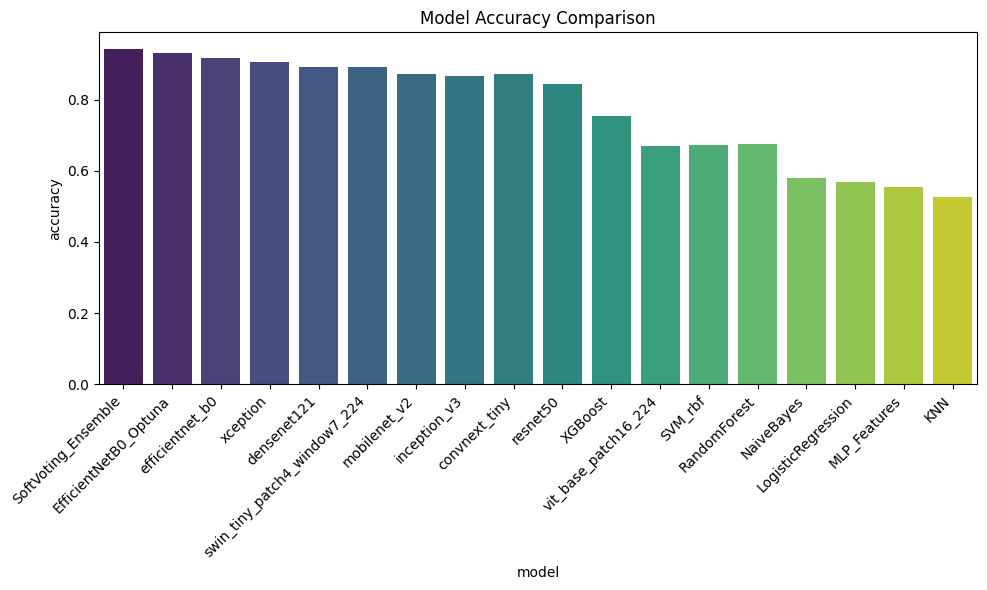

In [ ]:
import pandas as pd

# df must contain columns: ["model", "accuracy"]
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="model", y="accuracy", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3065063072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="model", y="f1_macro", palette="magma")


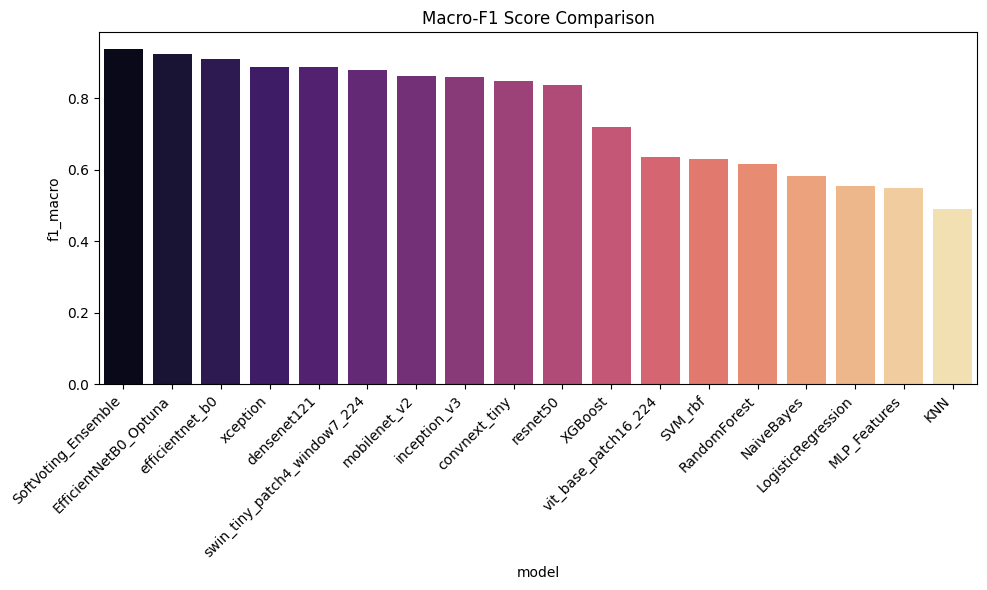

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="model", y="f1_macro", palette="magma")
plt.xticks(rotation=45, ha="right")
plt.title("Macro-F1 Score Comparison")
plt.tight_layout()
plt.show()


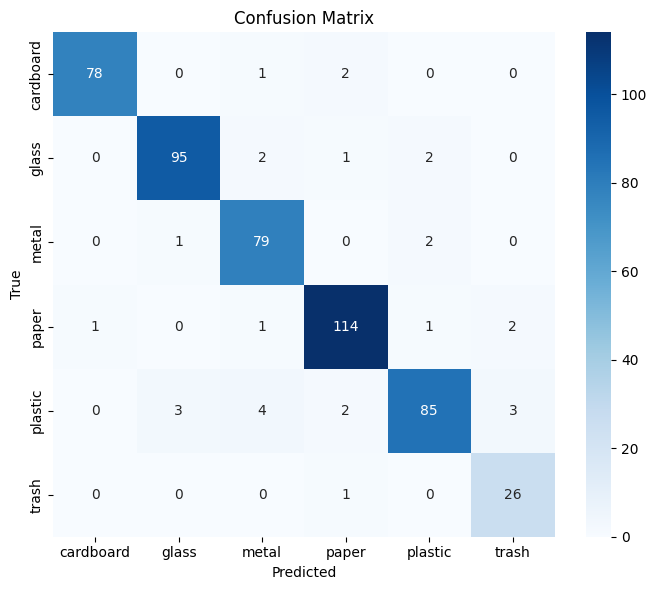

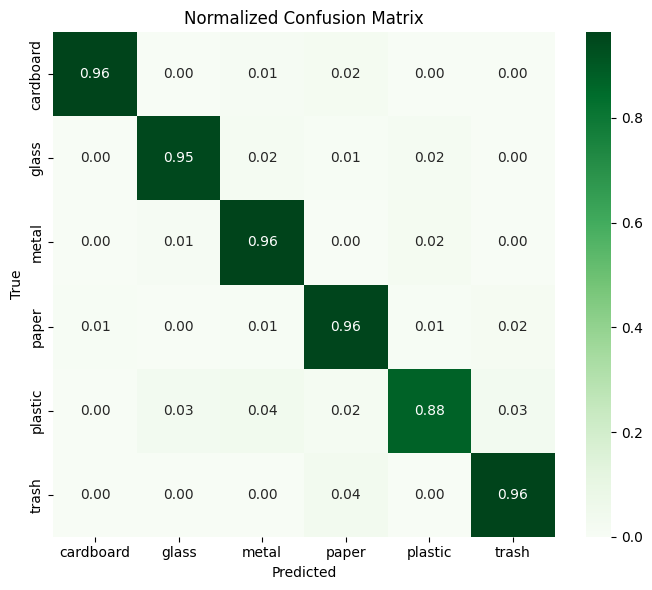

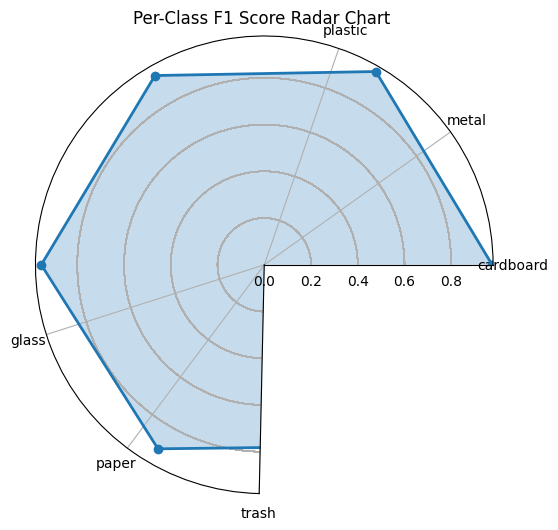

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# ============================================================
# 1. CONFUSION MATRIX (Counts)
# ============================================================
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)



# ============================================================
# 2. NORMALIZED CONFUSION MATRIX (Percentages)
# ============================================================
def plot_normalized_confusion(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=classes, yticklabels=classes)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

plot_normalized_confusion(y_true, y_pred, classes)



# ============================================================
# 3. PER-CLASS F1 RADAR CHART
# ============================================================
def plot_radar_f1(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    f1_scores = [report[c]["f1-score"] for c in classes]

    # close the circle
    f1 = f1_scores + f1_scores[:1]
    angles = np.linspace(0, 2 * np.pi, len(f1_scores), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, f1, marker='o', linewidth=2)
    ax.fill(angles, f1, alpha=0.25)
    ax.set_thetagrids(np.degrees(np.linspace(0, 360, len(classes), endpoint=False)), classes)
    plt.title("Per-Class F1 Score Radar Chart")
    plt.show()

plot_radar_f1(y_true, y_pred, classes)


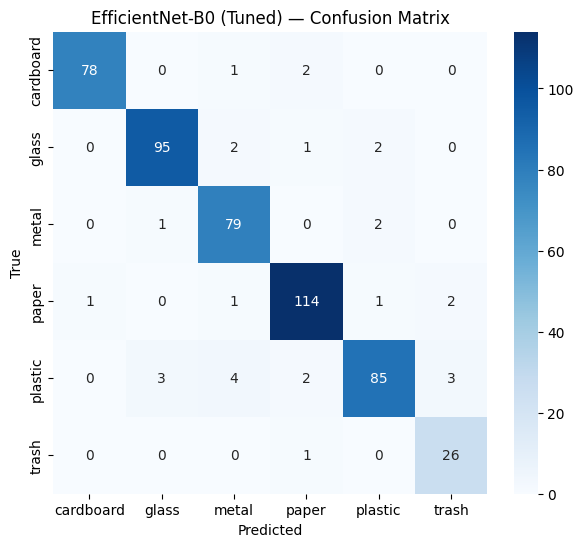

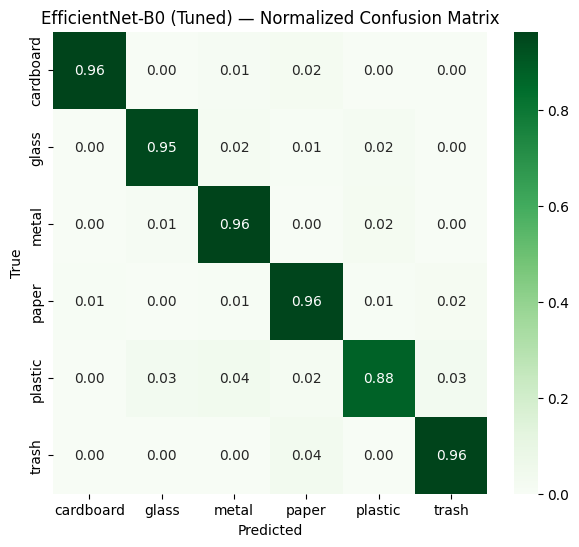

<Figure size 1000x600 with 0 Axes>

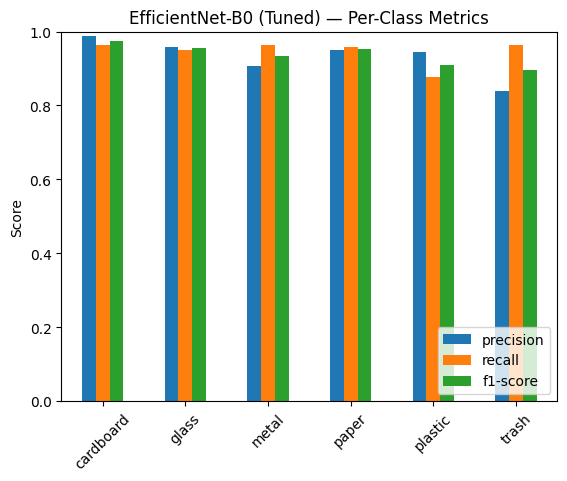

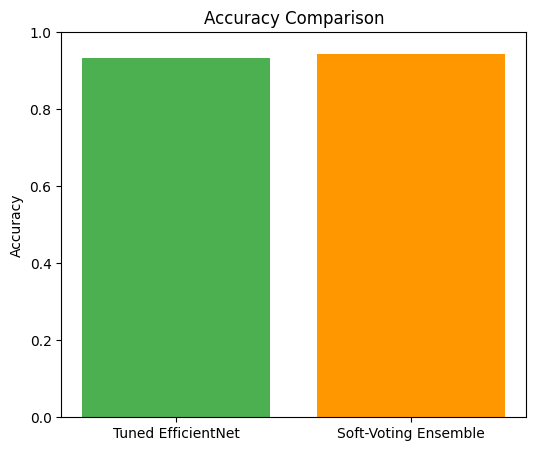

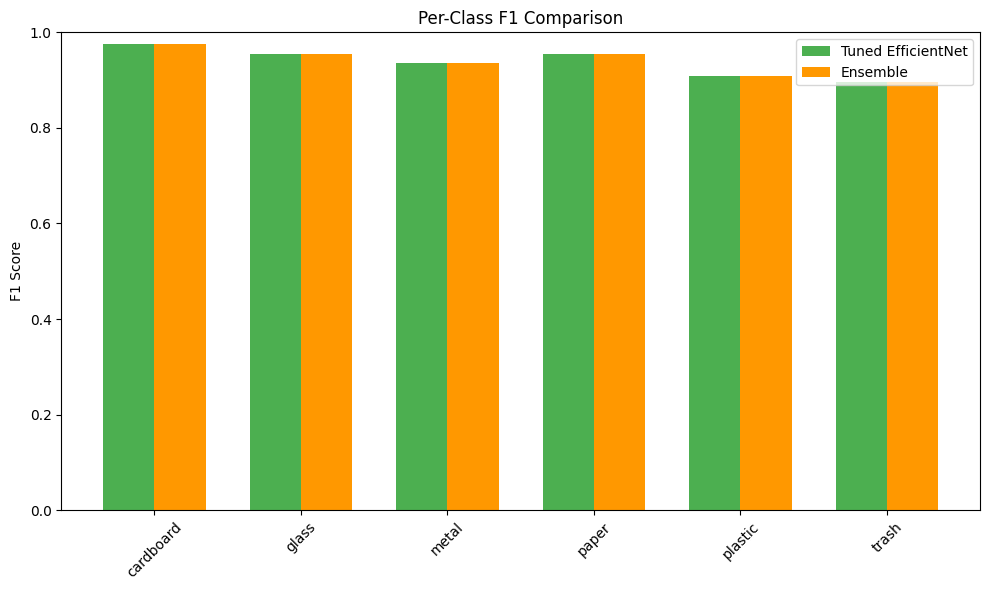

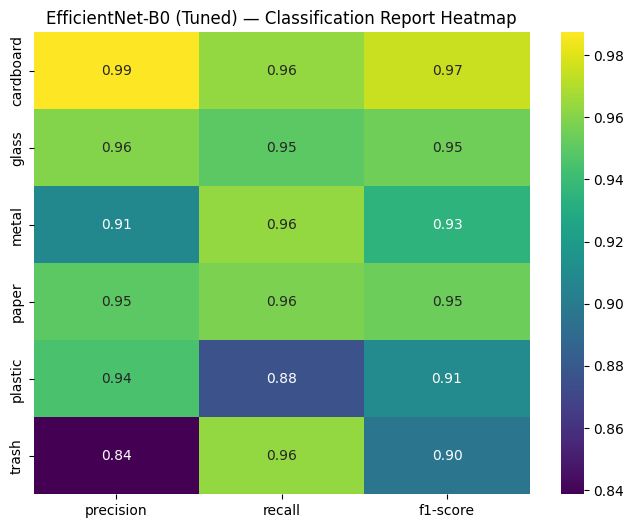

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ================
# 1️⃣ CONFUSION MATRIX
# ================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("EfficientNet-B0 (Tuned) — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ================
# 2️⃣ NORMALIZED CONFUSION MATRIX
# ================
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Greens',
            xticklabels=classes, yticklabels=classes)
plt.title("EfficientNet-B0 (Tuned) — Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ================
# 3️⃣ PER-CLASS PRECISION / RECALL / F1 BAR CHART
# ================
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3]  # remove avg rows

plt.figure(figsize=(10,6))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("EfficientNet-B0 (Tuned) — Per-Class Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.show()

# ================
# 4️⃣ ACCURACY COMPARISON: TUNED EFFICIENTNET vs ENSEMBLE
# ================
acc_tuned = final_m["accuracy"]
acc_ens   = ensemble_metrics["accuracy"]

plt.figure(figsize=(6,5))
plt.bar(["Tuned EfficientNet", "Soft-Voting Ensemble"],
        [acc_tuned, acc_ens],
        color=["#4CAF50", "#FF9800"])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

# ================
# 5️⃣ PER-CLASS F1 SCORES: TUNED EFFICIENTNET vs ENSEMBLE
# ================
# Ensemble per-class (compute fresh)
ens_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

tuned_f1 = df_report["f1-score"].values
ens_f1   = [ens_report[c]["f1-score"] for c in classes]

x = np.arange(len(classes))
w = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - w/2, tuned_f1, width=w, label="Tuned EfficientNet", color="#4CAF50")
plt.bar(x + w/2, ens_f1, width=w, label="Ensemble", color="#FF9800")
plt.xticks(x, classes, rotation=45)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Comparison")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()

# ================
# 6️⃣ HEATMAP OF CLASSIFICATION REPORT (TUNED EFFICIENTNET)
# ================
plt.figure(figsize=(8,6))
sns.heatmap(df_report[['precision','recall','f1-score']],
            annot=True, cmap='viridis', fmt=".2f")
plt.title("EfficientNet-B0 (Tuned) — Classification Report Heatmap")
plt.show()


Generating ROC curves for Tuned EfficientNet-B0...


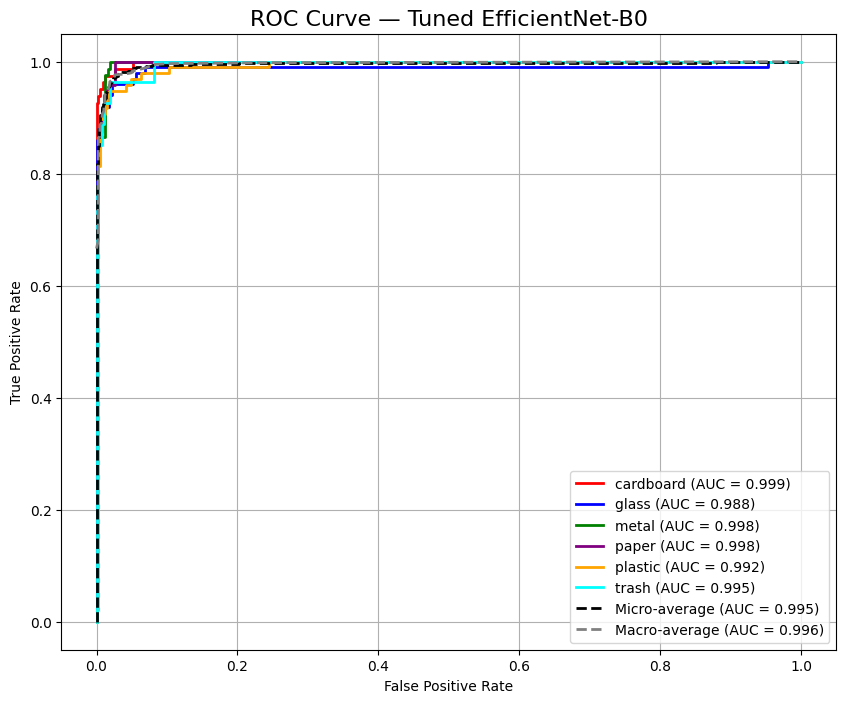

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

print("Generating ROC curves for Tuned EfficientNet-B0...")

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader_img:
        imgs = imgs.to(device)

        logits = model(imgs)
        probs = F.softmax(logits, dim=1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels.numpy())

# Convert lists → arrays
all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

# Binarize labels for multi-class ROC
y_bin = label_binarize(all_labels, classes=list(range(len(classes))))

# Store ROC AUC
roc_auc = {}

plt.figure(figsize=(10, 8))

colors = ["red", "blue", "green", "purple", "orange", "cyan"]

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i],
             label=f"{classes[i]} (AUC = {roc_auc[i]:.3f})", linewidth=2)

# MICRO AVERAGE
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', color="black",
         label=f"Micro-average (AUC = {roc_auc_micro:.3f})", linewidth=2)

# MACRO AVERAGE
all_fpr = np.unique(np.concatenate([roc_curve(y_bin[:, i], all_probs[:, i])[0] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= len(classes)
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, linestyle='--', color="gray",
         label=f"Macro-average (AUC = {roc_auc_macro:.3f})", linewidth=2)

# plot settings
plt.title("ROC Curve — Tuned EfficientNet-B0", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
